# DATA SCIENCE LAB

In [1006]:
import pandas as pd
import glob
import os
import numpy as np

# Forecasting time series with complex seasonal patterns
from tbats import TBATS, BATS

# Load mooving average methods
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
import pmdarima                            # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Load fbprophet
from fbprophet import Prophet

import matplotlib.pyplot as plt
import math
from datetime import date, timedelta
import dateutil.relativedelta as relativedelta
import holidays

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

pd.options.plotting.backend = 'matplotlib'
plt.style.use('default')

In [1007]:
frame = pd.read_csv('https://raw.githubusercontent.com/GianlucaSimionato/Data_Science_Lab/main/DB.csv', sep=';', decimal=',')

In [1008]:
frame.sort_values(by=['POD', 'DATE_TIME_MIN'], inplace=True)
frame['DATE_TIME'] = pd.to_datetime({'year':frame['YEAR'], 'month':frame['MONTH'], 'DAY':frame['DAY'], 'HOUR':frame['HOUR']})

In [1009]:

frame

POD      DATA     ORA  CONSUMO_ATTIVA_PRELEVATA  MINUTE  \
101748  IT012E00491824  20180101       0                     93.50       0   
101749  IT012E00491824  20180101    1500                     91.30      15   
101750  IT012E00491824  20180101    3000                     91.85      30   
101751  IT012E00491824  20180101    4500                     90.20      45   
101752  IT012E00491824  20180101   10000                     91.85       0   
...                ...       ...     ...                       ...     ...   
172290  IT012E00491869  20201231  224500                     54.00      45   
172291  IT012E00491869  20201231  230000                     53.40       0   
172292  IT012E00491869  20201231  231500                     54.60      15   
172293  IT012E00491869  20201231  233000                     55.20      30   
172294  IT012E00491869  20201231  234500                     53.40      45   

        HOUR  YEAR  MONTH  DAY        DATE_TIME_MIN           DATE_TIME  
101748     0  2018      1    1  2018-01-01 00:00:00 2018-01-01 00:00:00  
101749     0  2018      1    1  2018-01-01 00:15:00 2018-01-01 00:00:00  
101750     0  2018      1    1  2018-01-01 00:30:00 2018-01-01 00:00:00  
101751     0  2018      1    1  2018-01-01 00:45:00 2018-01-01 00:00:00  
101752     1  2018      1    1  2018-01-01 01:00:00 2018-01-01 01:00:00  
...      ...   ...    ...  ...                  ...                 ...  
172290    22  2020     12   31  2020-12-31 22:45:00 2020-12-31 22:00:00  
172291    23  2020     12   31  2020-12-31 23:00:00 2020-12-31 23:00:00  
172292    23  2020     12   31  2020-12-31 23:15:00 2020-12-31 23:00:00  
172293    23  2020     12   31  2020-12-31 23:30:00 2020-12-31 23:00:00  
172294    23  2020     12   31  2020-12-31 23:45:00 2020-12-31 23:00:00  

[207528 rows x 11 columns]

In [1010]:
start = frame.DATE_TIME.min()
end = '2021-12-31'
start, end

(Timestamp('2018-01-01 00:00:00'), '2021-12-31')

In [1011]:
df_cal = pd.DataFrame({"Date": pd.date_range(start, end)})
df_cal["Day"] = df_cal['Date'].dt.day_name()
df_cal["Week"] = df_cal['Date'].dt.weekofyear
df_cal["Month"] = df_cal['Date'].dt.month
df_cal["Month_name"] = df_cal['Date'].dt.month_name()
df_cal["Quarter"] = df_cal['Date'].dt.quarter
df_cal["Year"] = df_cal['Date'].dt.year
df_cal


Date        Day  Week  Month Month_name  Quarter  Year
0    2018-01-01     Monday     1      1    January        1  2018
1    2018-01-02    Tuesday     1      1    January        1  2018
2    2018-01-03  Wednesday     1      1    January        1  2018
3    2018-01-04   Thursday     1      1    January        1  2018
4    2018-01-05     Friday     1      1    January        1  2018
...         ...        ...   ...    ...        ...      ...   ...
1456 2021-12-27     Monday    52     12   December        4  2021
1457 2021-12-28    Tuesday    52     12   December        4  2021
1458 2021-12-29  Wednesday    52     12   December        4  2021
1459 2021-12-30   Thursday    52     12   December        4  2021
1460 2021-12-31     Friday    52     12   December        4  2021

[1461 rows x 7 columns]

In [1012]:
df_cal["Year"].max()+1
year_list

[2018, 2019, 2020, 2021, 2022]

In [1013]:
holiday_date = []
holiday_name = []
year_list =  list(df_cal["Year"].unique())
year_list.append(df_cal["Year"].max()+1)
for ptr in holidays.IT(years = year_list, prov='MI').items():
    holiday_date.append(ptr[0])
    holiday_name.append(ptr[1])
df_holiday = pd.DataFrame(list(zip(holiday_date, holiday_name)), columns =['Date', 'holiday_name'])
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])

In [1024]:
df_cal_holiday = pd.merge(df_cal, df_holiday, how='left', on='Date')
df_cal_holiday['dummy_holiday'] = np.where(df_cal_holiday['holiday_name']==df_cal_holiday['holiday_name'], 1, 0)
df_cal_holiday['dummy_Covid'] = np.where(df_cal_holiday['Date'] > '2020-03-01', 1, 0)
df_cal_holiday[df_cal_holiday['dummy_holiday']==1]

Date        Day  Week  Month Month_name  Quarter  Year  \
0    2018-01-01     Monday     1      1    January        1  2018   
5    2018-01-06   Saturday     1      1    January        1  2018   
90   2018-04-01     Sunday    13      4      April        2  2018   
91   2018-04-02     Monday    14      4      April        2  2018   
114  2018-04-25  Wednesday    17      4      April        2  2018   
120  2018-05-01    Tuesday    18      5        May        2  2018   
152  2018-06-02   Saturday    22      6       June        2  2018   
226  2018-08-15  Wednesday    33      8     August        3  2018   
304  2018-11-01   Thursday    44     11   November        4  2018   
340  2018-12-07     Friday    49     12   December        4  2018   
341  2018-12-08   Saturday    49     12   December        4  2018   
358  2018-12-25    Tuesday    52     12   December        4  2018   
359  2018-12-26  Wednesday    52     12   December        4  2018   
365  2019-01-01    Tuesday     1      1    January        1  2019   
370  2019-01-06     Sunday     1      1    January        1  2019   
475  2019-04-21     Sunday    16      4      April        2  2019   
476  2019-04-22     Monday    17      4      April        2  2019   
479  2019-04-25   Thursday    17      4      April        2  2019   
485  2019-05-01  Wednesday    18      5        May        2  2019   
517  2019-06-02     Sunday    22      6       June        2  2019   
591  2019-08-15   Thursday    33      8     August        3  2019   
669  2019-11-01     Friday    44     11   November        4  2019   
705  2019-12-07   Saturday    49     12   December        4  2019   
706  2019-12-08     Sunday    49     12   December        4  2019   
723  2019-12-25  Wednesday    52     12   December        4  2019   
724  2019-12-26   Thursday    52     12   December        4  2019   
730  2020-01-01  Wednesday     1      1    January        1  2020   
735  2020-01-06     Monday     2      1    January        1  2020   
832  2020-04-12     Sunday    15      4      April        2  2020   
833  2020-04-13     Monday    16      4      April        2  2020   
845  2020-04-25   Saturday    17      4      April        2  2020   
851  2020-05-01     Friday    18      5        May        2  2020   
883  2020-06-02    Tuesday    23      6       June        2  2020   
957  2020-08-15   Saturday    33      8     August        3  2020   
1035 2020-11-01     Sunday    44     11   November        4  2020   
1071 2020-12-07     Monday    50     12   December        4  2020   
1072 2020-12-08    Tuesday    50     12   December        4  2020   
1089 2020-12-25     Friday    52     12   December        4  2020   
1090 2020-12-26   Saturday    52     12   December        4  2020   
1096 2021-01-01     Friday    53      1    January        1  2021   
1101 2021-01-06  Wednesday     1      1    January        1  2021   
1189 2021-04-04     Sunday    13      4      April        2  2021   
1190 2021-04-05     Monday    14      4      April        2  2021   
1210 2021-04-25     Sunday    16      4      April        2  2021   
1216 2021-05-01   Saturday    17      5        May        2  2021   
1248 2021-06-02  Wednesday    22      6       June        2  2021   
1322 2021-08-15     Sunday    32      8     August        3  2021   
1400 2021-11-01     Monday    44     11   November        4  2021   
1436 2021-12-07    Tuesday    49     12   December        4  2021   
1437 2021-12-08  Wednesday    49     12   December        4  2021   
1454 2021-12-25   Saturday    51     12   December        4  2021   
1455 2021-12-26     Sunday    51     12   December        4  2021   

                  holiday_name  dummy_holiday  dummy_Covid  
0                    Capodanno              1            0  
5         Epifania del Signore              1            0  
90      Pasqua di Resurrezione              1            0  
91          Lunedì dell'Angelo              1            0  
114    Festa della Liberazione              1   

In [1146]:
frame_grouped = frame.groupby(['POD', 'YEAR', 'MONTH', 'DAY', 'HOUR'], as_index=False).mean()
frame_grouped['DATE_TIME'] = pd.to_datetime({'year':frame_grouped['YEAR'], 'month':frame_grouped['MONTH'], 'DAY':frame_grouped['DAY'], 'HOUR':frame_grouped['HOUR']})
frame_grouped = frame_grouped[['POD', 'CONSUMO_ATTIVA_PRELEVATA', 'DATE_TIME']]
frame_hour = frame_grouped.set_index('DATE_TIME')
df_complete_POD1 = frame_hour[frame_hour['POD'] == 'IT012E00491869'][['CONSUMO_ATTIVA_PRELEVATA']]

In [1026]:
frame_g = frame.groupby(['POD', 'YEAR', 'MONTH', 'DAY'], as_index=False).mean()
frame_g['DATE_TIME'] = pd.to_datetime({'year':frame_g['YEAR'], 'month':frame_g['MONTH'], 'DAY':frame_g['DAY']})
frame_g = frame_g[['POD', 'CONSUMO_ATTIVA_PRELEVATA', 'DATE_TIME']]
frame_g = frame_g.set_index('DATE_TIME')


In [1178]:
POD_1 = 'IT012E00491869'
df_1 = frame_g[frame_g['POD'] == POD_1]
df_1.sort_index(ascending=True, inplace=True)
df_1 = df_1[['CONSUMO_ATTIVA_PRELEVATA']]
POD_2 = 'IT012E00491824'
df_2 = frame_g[frame_g['POD'] == POD_2]
df_2.sort_index(ascending=True, inplace=True)
df_2 = df_2[['CONSUMO_ATTIVA_PRELEVATA']]

In [1028]:
df_2['year']=df_2.index.year.astype(str)
df_2['Month']=df_2.index.month.astype(str)
df_2['Day']=df_2.index.weekday.astype(str)

df_1['year']=df_1.index.year.astype(str)
df_1['Month']=df_1.index.month.astype(str)
df_1['Day']=df_1.index.weekday.astype(str)

<AxesSubplot:title={'center':'CONSUMO_ATTIVA_PRELEVATA'}, xlabel='[year]'>

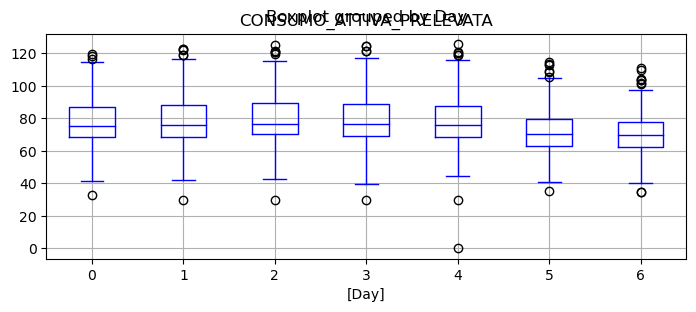

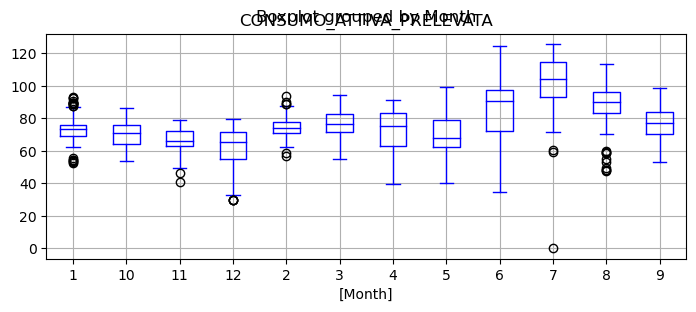

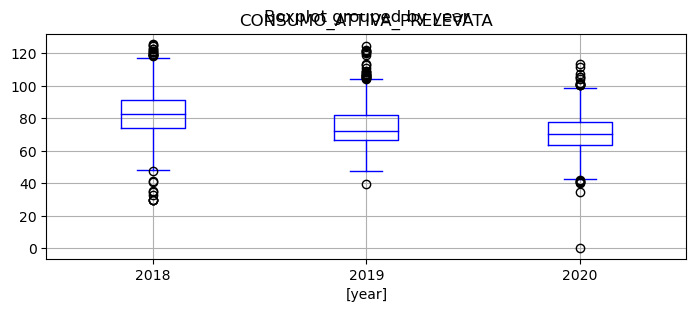

In [1029]:
# BOXPLOT
df_1.boxplot(by='Day',figsize=(8,3), color='blue')
df_1.boxplot(by='Month',figsize=(8,3), color='blue')
df_1.boxplot(by='year',figsize=(8,3), color='blue')

<AxesSubplot:title={'center':'CONSUMO_ATTIVA_PRELEVATA'}, xlabel='[year]'>

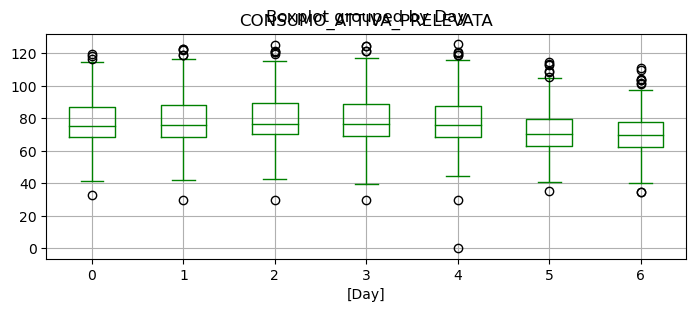

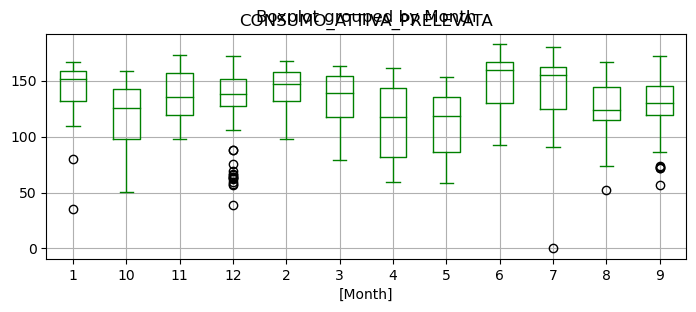

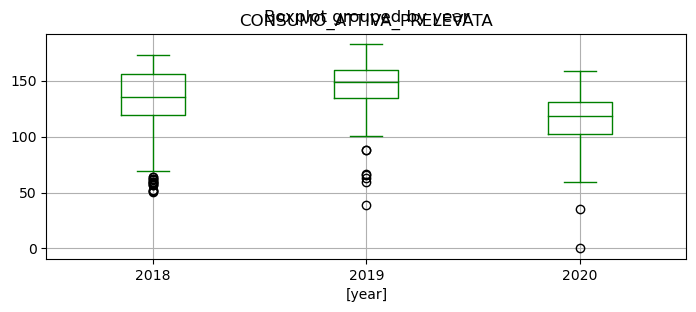

In [1030]:
df_1.boxplot(by='Day',figsize=(8,3), color='green')
df_2.boxplot(by='Month',figsize=(8,3), color='green')
df_2.boxplot(by='year',figsize=(8,3), color='green')

<AxesSubplot:xlabel='DATE_TIME'>

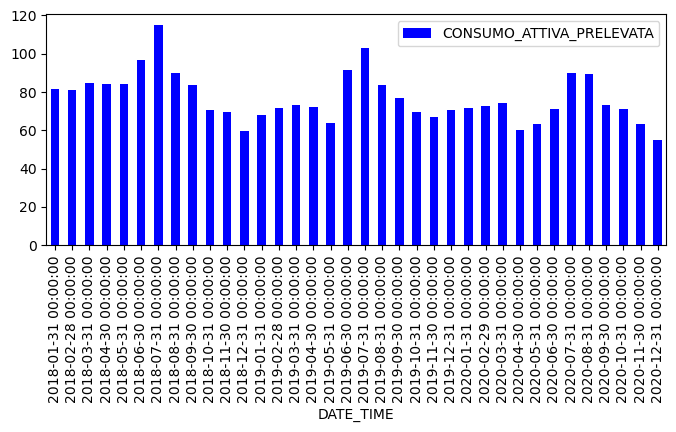

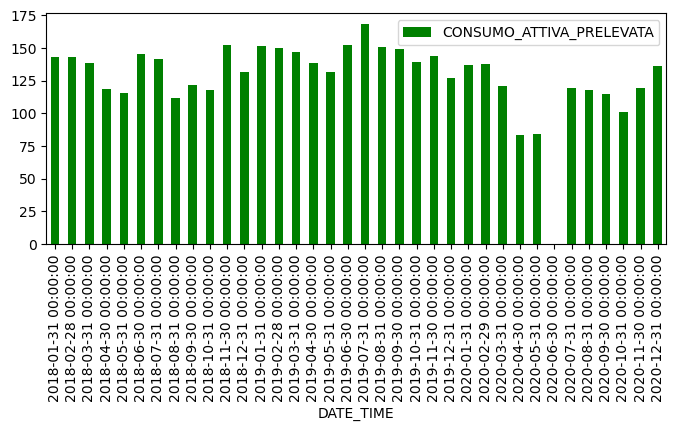

In [1031]:
#BAR CHART
df_1.resample('M').mean().plot.bar(figsize=(8,3), color='blue')
df_2.resample('M').mean().plot.bar(figsize=(8,3), color='green')

In [1032]:
df_cal_holiday.set_index('Date', inplace=True)


In [1033]:
df_cal_holiday

Day  Week  Month Month_name  Quarter  Year holiday_name  \
Date                                                                        
2018-01-01     Monday     1      1    January        1  2018    Capodanno   
2018-01-02    Tuesday     1      1    January        1  2018          NaN   
2018-01-03  Wednesday     1      1    January        1  2018          NaN   
2018-01-04   Thursday     1      1    January        1  2018          NaN   
2018-01-05     Friday     1      1    January        1  2018          NaN   
...               ...   ...    ...        ...      ...   ...          ...   
2021-12-27     Monday    52     12   December        4  2021          NaN   
2021-12-28    Tuesday    52     12   December        4  2021          NaN   
2021-12-29  Wednesday    52     12   December        4  2021          NaN   
2021-12-30   Thursday    52     12   December        4  2021          NaN   
2021-12-31     Friday    52     12   December        4  2021          NaN   

            dummy_holiday  dummy_Covid  
Date                                    
2018-01-01              1            0  
2018-01-02              0            0  
2018-01-03              0            0  
2018-01-04              0            0  
2018-01-05              0            0  
...                   ...          ...  
2021-12-27              0            1  
2021-12-28              0            1  
2021-12-29              0            1  
2021-12-30              0            1  
2021-12-31              0            1  

[1461 rows x 9 columns]

In [1034]:
df_1 = pd.merge(df_1, df_cal_holiday[['dummy_holiday', 'dummy_Covid']], left_index=True, right_index=True)
df_1

CONSUMO_ATTIVA_PRELEVATA  year Month Day  dummy_holiday  \
2018-01-01                  64.30000  2018     1   0              1   
2018-01-02                  70.08125  2018     1   1              0   
2018-01-03                  75.38750  2018     1   2              0   
2018-01-04                  74.46250  2018     1   3              0   
2018-01-05                  75.86250  2018     1   4              0   
...                              ...   ...   ...  ..            ...   
2020-12-27                  54.95625  2020    12   6              0   
2020-12-28                  54.63750  2020    12   0              0   
2020-12-29                  54.71875  2020    12   1              0   
2020-12-30                  54.79375  2020    12   2              0   
2020-12-31                  54.20625  2020    12   3              0   

            dummy_Covid  
2018-01-01            0  
2018-01-02            0  
2018-01-03            0  
2018-01-04            0  
2018-01-05            0  
...                 ...  
2020-12-27            1  
2020-12-28            1  
2020-12-29            1  
2020-12-30            1  
2020-12-31            1  

[1096 rows x 6 columns]

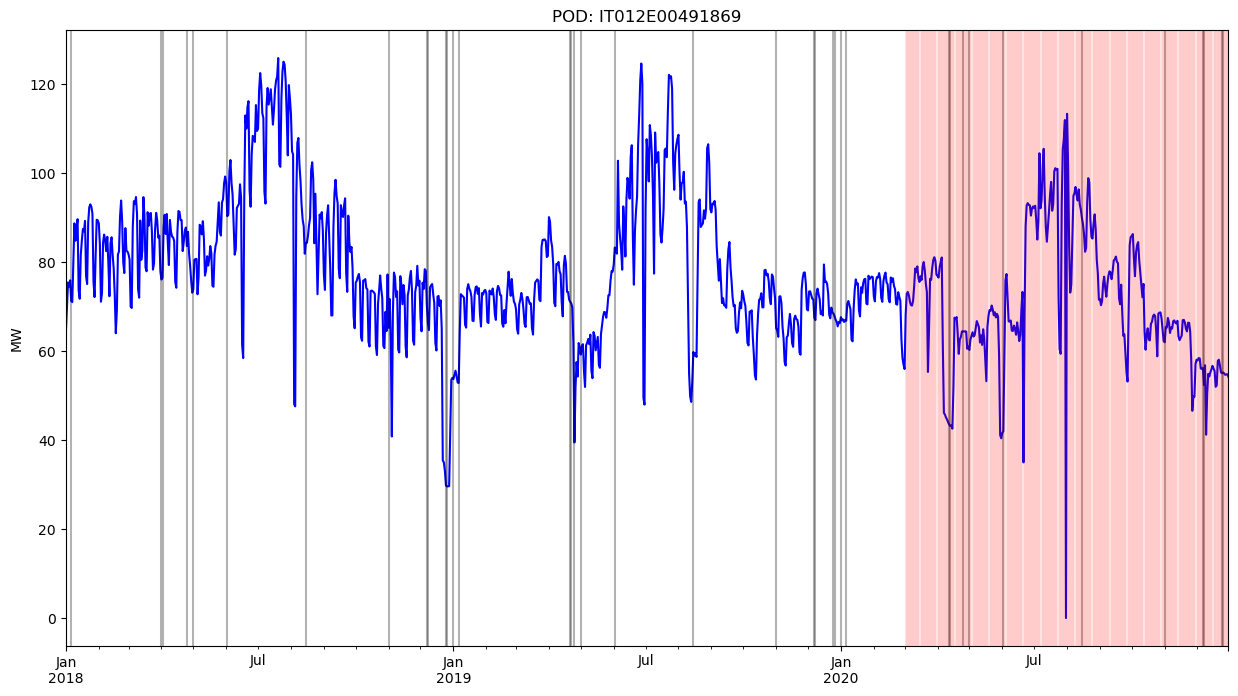

In [872]:
#LINE CHARET
ax = df_1['CONSUMO_ATTIVA_PRELEVATA'].resample('d').mean().plot(figsize=(15,8), color='blue', title = 'POD: IT012E00491869')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
for x in df_1.query('dummy_holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3)
for x in df_1.query('dummy_Covid==1').index: 
    ax.axvline(x=x, color='r', alpha = 0.1);


In [873]:
df_2 = pd.merge(df_2, df_cal_holiday[['dummy_holiday', 'dummy_Covid']], left_index=True, right_index=True)

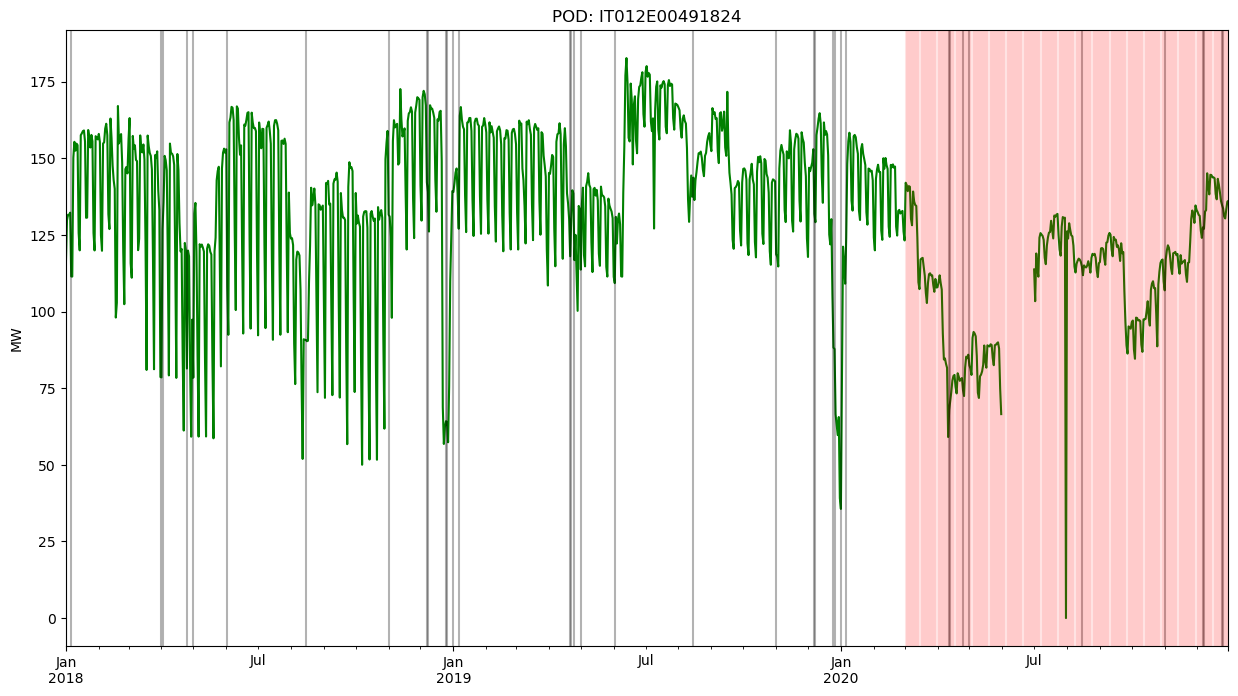

In [874]:
#LINE CHARET
ax = df_2['CONSUMO_ATTIVA_PRELEVATA'].resample('d').mean().plot(figsize=(15,8), color='green', title = 'POD: IT012E00491824')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
for x in df_2.query('dummy_holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);
for x in df_1.query('dummy_Covid==1').index: 
    ax.axvline(x=x, color='r', alpha = 0.1);

## Statsmodels

In [761]:
df = df_1.copy()

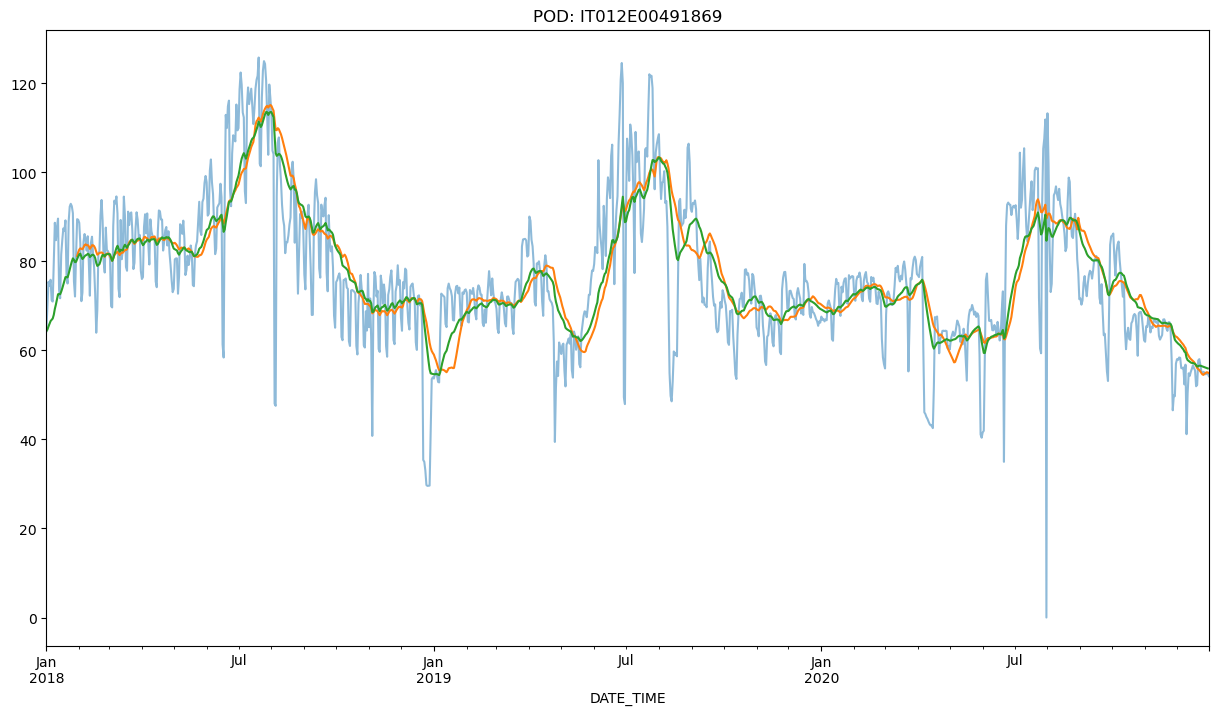

In [762]:

# MEDIE MOBILI
df['SMA30'] = df['CONSUMO_ATTIVA_PRELEVATA'].rolling(window = 30).mean()
df['SES30'] = SimpleExpSmoothing(df['CONSUMO_ATTIVA_PRELEVATA']).fit(smoothing_level=2/(30+1),optimized=False).fittedvalues.shift(-1)
df['CONSUMO_ATTIVA_PRELEVATA'].plot(figsize=(15,8), alpha=0.5, title = 'POD: IT012E00491869').autoscale(axis='x',tight=True)
df['SMA30'].plot(figsize=(15,8)).autoscale(axis='x',tight=True)
df['SES30'].plot(figsize=(15,8)).autoscale(axis='x',tight=True)


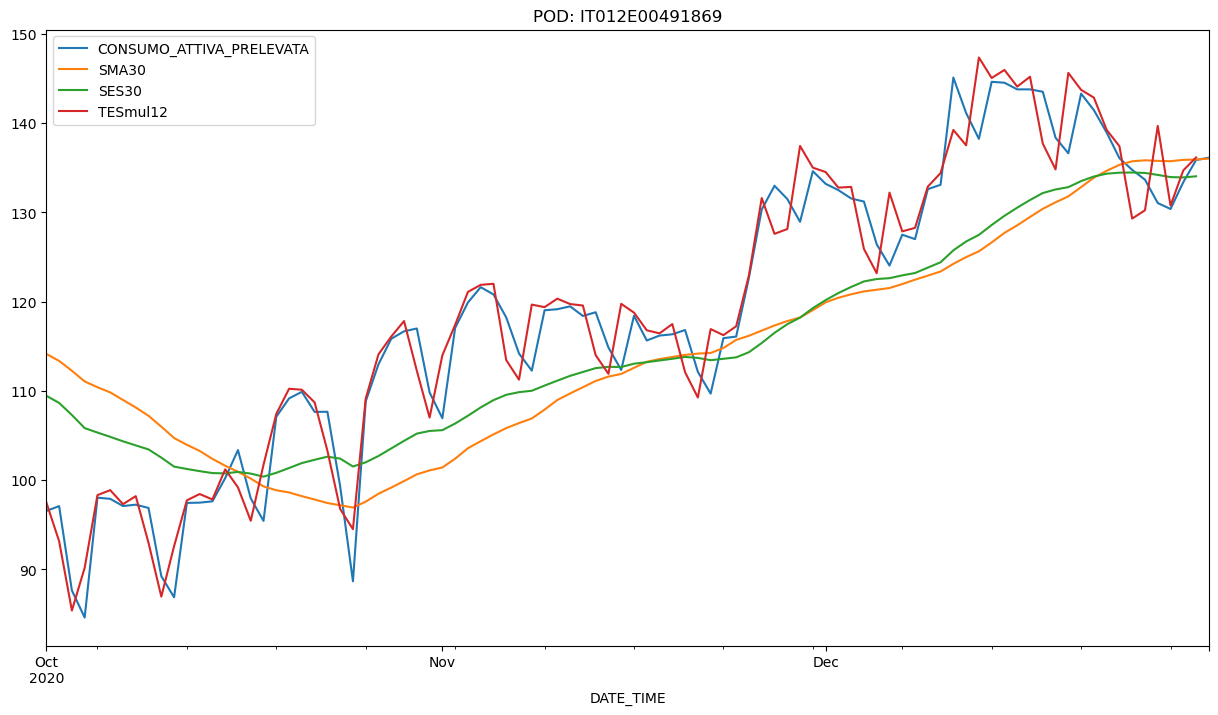

In [767]:
df = df.loc['2020-10-01':]
df['TESmul12'] = ExponentialSmoothing(df['CONSUMO_ATTIVA_PRELEVATA'], trend='mul', seasonal='mul',seasonal_periods = 7).fit().fittedvalues.shift(-1)
df.plot(figsize=(15,8), title = 'POD: IT012E00491869').autoscale(axis='x', tight=True);

In [764]:
df = df_2.copy()

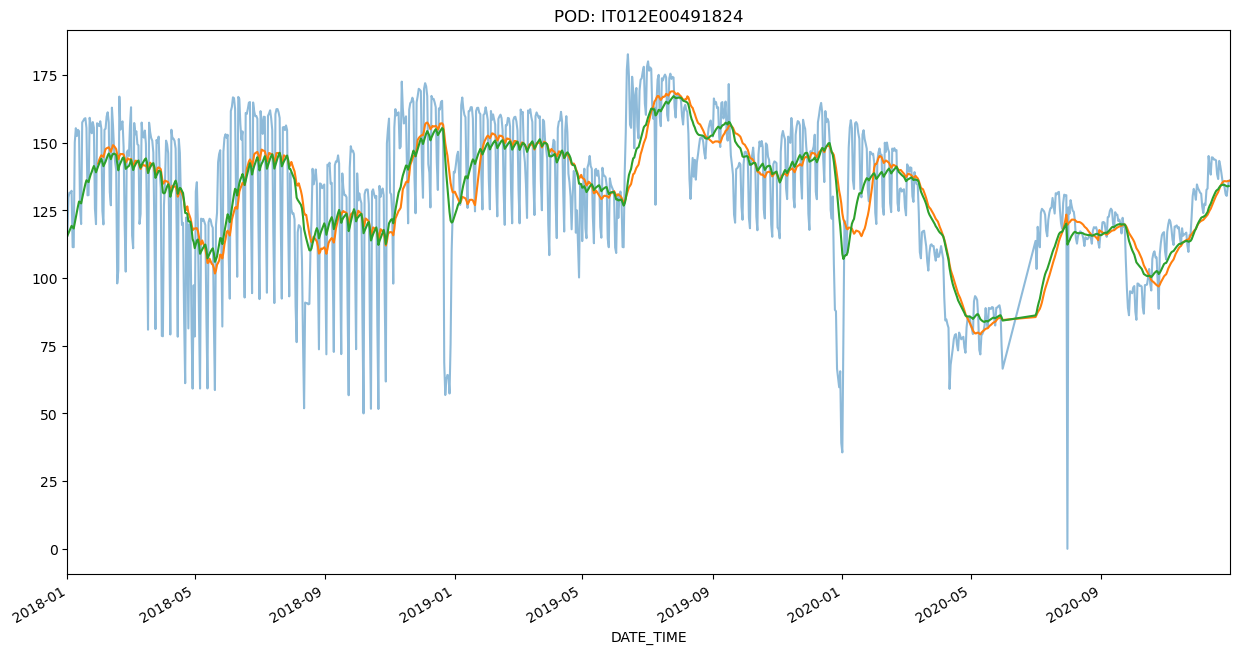

In [765]:
# MEDIE MOBILI
df['SMA30'] = df['CONSUMO_ATTIVA_PRELEVATA'].rolling(window = 30).mean()
df['SES30'] = SimpleExpSmoothing(df['CONSUMO_ATTIVA_PRELEVATA']).fit(smoothing_level=2/(30+1),optimized=False).fittedvalues.shift(-1)
df['CONSUMO_ATTIVA_PRELEVATA'].plot(figsize=(15,8), alpha=0.5, title = 'POD: IT012E00491824').autoscale(axis='x',tight=True)
df['SMA30'].plot(figsize=(15,8)).autoscale(axis='x',tight=True)
df['SES30'].plot(figsize=(15,8)).autoscale(axis='x',tight=True)

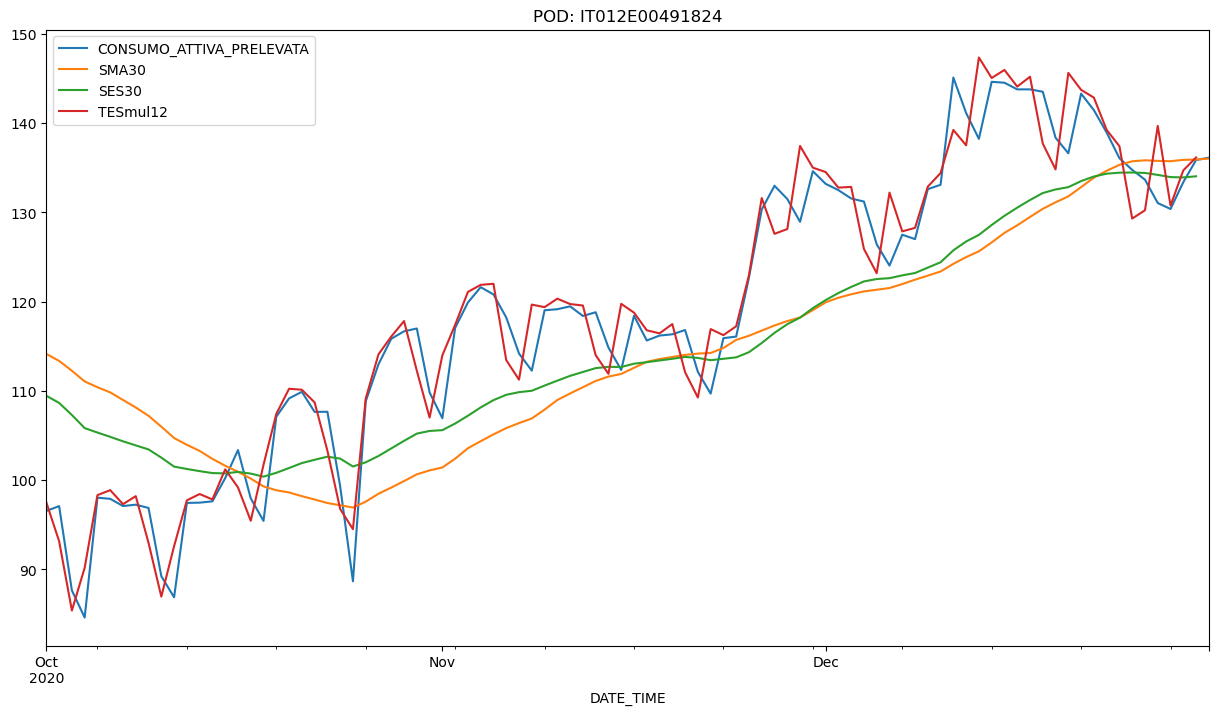

In [768]:
df = df.loc['2020-10-01':]
df['TESmul12'] = ExponentialSmoothing(df['CONSUMO_ATTIVA_PRELEVATA'], trend='mul', seasonal='mul',seasonal_periods = 7).fit().fittedvalues.shift(-1)
df.plot(figsize=(15,8), title = 'POD: IT012E00491824').autoscale(axis='x', tight=True);

## Forecasting
Facciamo una previsione dei dati mancanti su Giugno 2020

### SARIMA 
Forecat Mensile

In [774]:
frame_MONTH = frame.groupby(['POD', 'YEAR', 'MONTH'], as_index=False).mean()
df = frame_MONTH[frame_MONTH['POD'] == 'IT012E00491824']
df['DATE_TIME'] = pd.to_datetime({'year':df['YEAR'], 'month':df['MONTH'], 'day':'01'})
df = df.set_index('DATE_TIME')
df = df[['CONSUMO_ATTIVA_PRELEVATA']]
df.sort_index(ascending=True, inplace=True)
df.columns = ['Y']
df_orig = df.copy()

In [775]:
df.resample('MS').mean()

Y
DATE_TIME             
2018-01-01  142.734610
2018-02-01  142.928385
2018-03-01  138.327221
2018-04-01  118.270052
2018-05-01  115.575773
2018-06-01  145.535156
2018-07-01  141.269237
2018-08-01  111.776042
2018-09-01  121.753385
2018-10-01  117.577470
2018-11-01  152.537726
2018-12-01  131.930326
2019-01-01  151.674328
2019-02-01  149.708036
2019-03-01  146.753398
2019-04-01  138.130590
2019-05-01  131.541297
2019-06-01  151.949722
2019-07-01  168.263222
2019-08-01  150.932124
2019-09-01  149.520174
2019-10-01  138.947816
2019-11-01  144.231007
2019-12-01  127.301714
2020-01-01  137.310568
2020-02-01  137.743786
2020-03-01  120.958176
2020-04-01   83.502413
2020-05-01   84.463256
2020-06-01         NaN
2020-07-01  119.469758
2020-08-01  117.662298
2020-09-01  114.780417
2020-10-01  100.926294
2020-11-01  119.032031
2020-12-01  135.920413

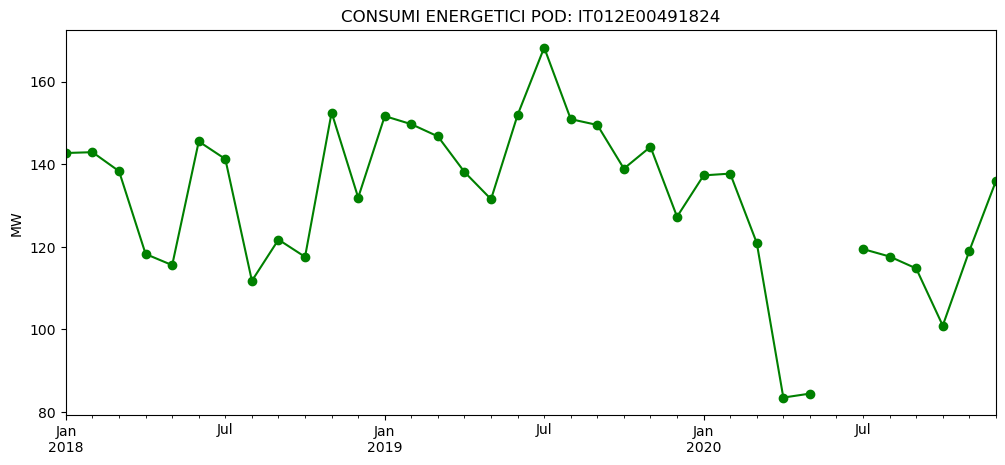

In [776]:
# Plot the source data
title='CONSUMI ENERGETICI POD: IT012E00491824'
ylabel='MW'
xlabel='' 
ax = df.resample('MS').mean().plot(figsize=(12,5),title=title, color = 'green', marker='o', legend=False)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


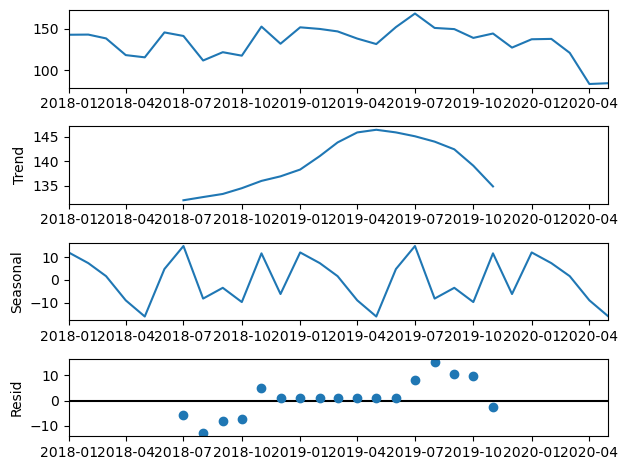

In [777]:
# ETS Decomposition
df = df.loc['2018-01-01' : '2020-05-01']

df.index.freq = 'MS'
result = seasonal_decompose(df, model='add')
result.plot();

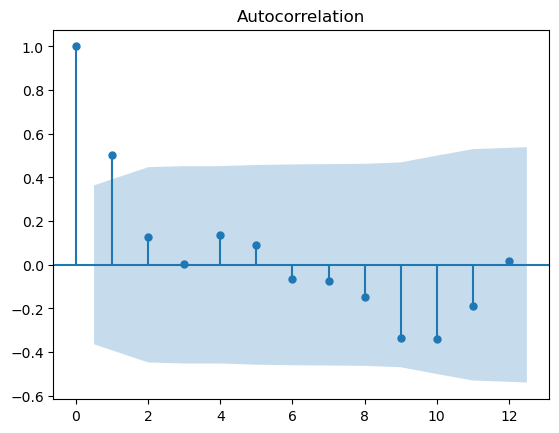

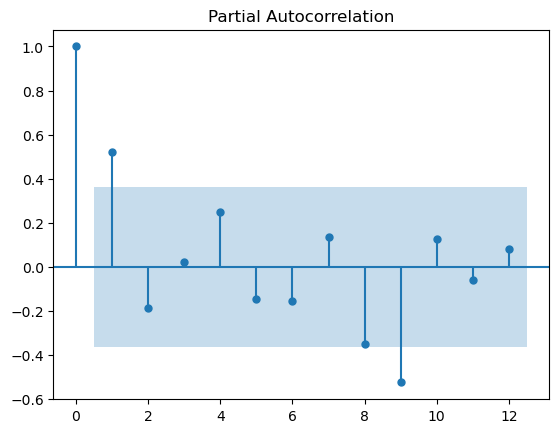

In [778]:
# Draw ACF and PACF Plot Charts
plot_acf(df.values.squeeze(), lags=12)
plot_pacf(df.values.squeeze(), lags=12)
plt.show()

In [779]:
Msarima = pmdarima.auto_arima(df['Y'], seasonal=True, m=12)

In [780]:
Msarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   29
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -118.045
Date:                            Sat, 01 May 2021   AIC                            244.091
Time:                                    15:31:57   BIC                            249.560
Sample:                                         0   HQIC                           245.804
                                             - 29                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.8301     13.505      0.802      0.423     -15.639      37.299
ar.L1          0.7881      0.185      4.263      0.000       0.426       1.150
ar.S.L12       0.5970      0.240      2.492      0.013       0.127       1.067
sigma2       161.5237     50.106      3.224      0.001      63.317     259.730
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.72   Prob(JB):                         0.50
Heteroskedasticity (H):               1.38   Skew:                            -0.31
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [781]:
# Run pmdarima.auto_arima to obtain recommended orders
par = Msarima.get_params()
order = par['order']
seasonal_order = par['seasonal_order']

In [782]:
# Train the model on the full data and forecast one year into the future
model = SARIMAX(df['Y'], order=order, seasonal_order=seasonal_order)
results = model.fit()
fcast = results.predict(len(df), len(df), typ='levels').rename(f'SARIMA{order}{seasonal_order} Forecast')

In [783]:
fcast

2020-06-01    98.826581
Freq: MS, Name: SARIMA(1, 0, 0)(1, 0, 0, 12) Forecast, dtype: float64

In [784]:
df_orig.resample('MS').mean()


Y
DATE_TIME             
2018-01-01  142.734610
2018-02-01  142.928385
2018-03-01  138.327221
2018-04-01  118.270052
2018-05-01  115.575773
2018-06-01  145.535156
2018-07-01  141.269237
2018-08-01  111.776042
2018-09-01  121.753385
2018-10-01  117.577470
2018-11-01  152.537726
2018-12-01  131.930326
2019-01-01  151.674328
2019-02-01  149.708036
2019-03-01  146.753398
2019-04-01  138.130590
2019-05-01  131.541297
2019-06-01  151.949722
2019-07-01  168.263222
2019-08-01  150.932124
2019-09-01  149.520174
2019-10-01  138.947816
2019-11-01  144.231007
2019-12-01  127.301714
2020-01-01  137.310568
2020-02-01  137.743786
2020-03-01  120.958176
2020-04-01   83.502413
2020-05-01   84.463256
2020-06-01         NaN
2020-07-01  119.469758
2020-08-01  117.662298
2020-09-01  114.780417
2020-10-01  100.926294
2020-11-01  119.032031
2020-12-01  135.920413

In [785]:
df_merge = pd.merge(df_orig, fcast, left_index=True, right_index=True, how='outer')
df_merge['Y'].loc['2020-06-01'] = df_merge['SARIMA(1, 0, 0)(1, 0, 0, 12) Forecast'].loc['2020-06-01']
df_merge

Y  SARIMA(1, 0, 0)(1, 0, 0, 12) Forecast
2018-01-01  142.734610                                    NaN
2018-02-01  142.928385                                    NaN
2018-03-01  138.327221                                    NaN
2018-04-01  118.270052                                    NaN
2018-05-01  115.575773                                    NaN
2018-06-01  145.535156                                    NaN
2018-07-01  141.269237                                    NaN
2018-08-01  111.776042                                    NaN
2018-09-01  121.753385                                    NaN
2018-10-01  117.577470                                    NaN
2018-11-01  152.537726                                    NaN
2018-12-01  131.930326                                    NaN
2019-01-01  151.674328                                    NaN
2019-02-01  149.708036                                    NaN
2019-03-01  146.753398                                    NaN
2019-04-01  138.130590                                    NaN
2019-05-01  131.541297                                    NaN
2019-06-01  151.949722                                    NaN
2019-07-01  168.263222                                    NaN
2019-08-01  150.932124                                    NaN
2019-09-01  149.520174                                    NaN
2019-10-01  138.947816                                    NaN
2019-11-01  144.231007                                    NaN
2019-12-01  127.301714                                    NaN
2020-01-01  137.310568                                    NaN
2020-02-01  137.743786                                    NaN
2020-03-01  120.958176                                    NaN
2020-04-01   83.502413                                    NaN
2020-05-01   84.463256                                    NaN
2020-06-01   98.826581                              98.826581
2020-07-01  119.469758                                    NaN
2020-08-01  117.662298                                    NaN
2020-09-01  114.780417                                    NaN
2020-10-01  100.926294                                    NaN
2020-11-01  119.032031                                    NaN
2020-12-01  135.920413                                    NaN

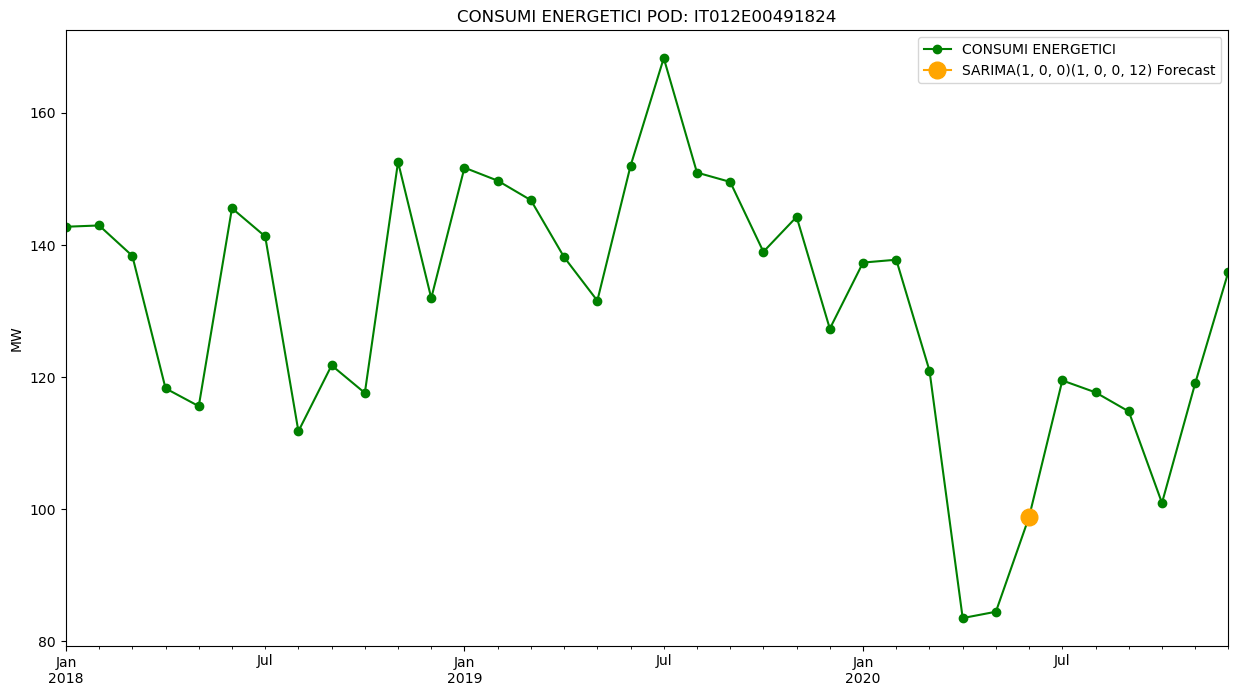

In [791]:
# Plot the forecasted values alongside the original data
title='CONSUMI ENERGETICI POD: IT012E00491824'
ylabel='MW'
xlabel='' 
df_merge.columns = ['CONSUMI ENERGETICI', 'SARIMA(1, 0, 0)(1, 0, 0, 12) Forecast']
ax = df_merge['CONSUMI ENERGETICI'].plot(legend=True,figsize=(15,8),title=title, color = 'green', marker='o')
df_merge['SARIMA(1, 0, 0)(1, 0, 0, 12) Forecast'].plot(legend=True,title=title, marker='o', markersize=12, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## TBATS
Exponential smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components 
TBATS do not allow for exogenous variables 

https://pkg.robjhyndman.com/forecast/reference/tbats.html

In [1077]:
frame_MONTH = frame.groupby(['POD', 'YEAR', 'MONTH', 'DAY'], as_index=False).mean()
df = frame_MONTH[frame_MONTH['POD'] == 'IT012E00491824']
df['DATE_TIME'] = pd.to_datetime({'year' : df['YEAR'], 'month' : df['MONTH'], 'day' : df['DAY']})
df = df.set_index('DATE_TIME')
df = df[['CONSUMO_ATTIVA_PRELEVATA']]
df.sort_index(ascending = True, inplace = True)
df.columns = ['Y']
df_complete = df.copy()
df = df.loc[: '2020-05-30']

In [259]:
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365))
model = estimator.fit(df)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)

In [261]:
from datetime import date, timedelta
l = []
sdate = date(2020, 6, 1)   # start date
edate = date(2021, 6, 1)   # end date
delta = edate - sdate       # as timedelta

for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    l.append(day)

In [1078]:
df_prev = pd.DataFrame(list(zip(l, y_forecast)), columns =['DATA', 'Y'])

df_prev = df_prev.set_index(pd.DatetimeIndex(df_prev['DATA']))

df_prev = df_prev.drop(['DATA'], axis=1)

In [1079]:
df_for = df_prev.loc['2020-06-01': '2020-07-01']


In [1080]:
df_for = pd.concat([df.loc[ : '2020-05-31'], df_prev_jun], axis=0)
df_for = df_for.loc['2020-06-01': '2020-06-30']
df_for

Y
2020-06-01   64.805299
2020-06-02   99.936666
2020-06-03   99.995481
2020-06-04  100.840297
2020-06-05  101.388765
2020-06-06  100.666984
2020-06-07   80.215439
2020-06-08   70.408675
2020-06-09  106.492780
2020-06-10  107.170064
2020-06-11  108.473730
2020-06-12  109.970091
2020-06-13  109.341844
2020-06-14   88.904702
2020-06-15   79.108296
2020-06-16  115.173293
2020-06-17  115.792445
2020-06-18  117.086735
2020-06-19  118.535584
2020-06-20  117.813631
2020-06-21   97.235878
2020-06-22   87.248777
2020-06-23  123.068700
2020-06-24  123.397795
2020-06-25  124.358384
2020-06-26  125.431174
2020-06-27  124.292576
2020-06-28  103.259377
2020-06-29   92.779383
2020-06-30  128.071630

In [1081]:
df_complete_tot = df_complete.copy()
df_complete_tot.columns = ['Y']
df_complete_tot_1 = df_complete_tot.loc[: '2020-05-31']
df_complete_tot_2 = df_complete_tot.loc['2020-07-01' :]
df_complete_tot = pd.concat([df_complete_tot_1, df_for, df_complete_tot_2], axis=0)
df_complete_tot.loc['2020-06-01':]

Y
2020-06-01   64.805299
2020-06-02   99.936666
2020-06-03   99.995481
2020-06-04  100.840297
2020-06-05  101.388765
...                ...
2020-12-27  131.037500
2020-12-28  130.367187
2020-12-29  133.375000
2020-12-30  135.855729
2020-12-31  136.119271

[214 rows x 1 columns]

Trovaimo la distribuzione media delle ore all'intenro della giornata da applicare a Giugno-20

In [1099]:
frame_grouped = frame.groupby(['POD', 'YEAR', 'MONTH', 'DAY', 'HOUR'], as_index=False).mean()
frame_hour = frame_grouped[frame_grouped['POD'] == 'IT012E00491824']
frame_hour

POD  YEAR  MONTH  DAY  HOUR        DATA       ORA  \
0      IT012E00491824  2018      1    1     0  20180101.0    2250.0   
1      IT012E00491824  2018      1    1     1  20180101.0   12250.0   
2      IT012E00491824  2018      1    1     2  20180101.0   22250.0   
3      IT012E00491824  2018      1    1     3  20180101.0   32250.0   
4      IT012E00491824  2018      1    1     4  20180101.0   42250.0   
...               ...   ...    ...  ...   ...         ...       ...   
25576  IT012E00491824  2020     12   31    19  20201231.0  192250.0   
25577  IT012E00491824  2020     12   31    20  20201231.0  202250.0   
25578  IT012E00491824  2020     12   31    21  20201231.0  212250.0   
25579  IT012E00491824  2020     12   31    22  20201231.0  222250.0   
25580  IT012E00491824  2020     12   31    23  20201231.0  232250.0   

       CONSUMO_ATTIVA_PRELEVATA  MINUTE  
0                       91.7125    22.5  
1                       91.1625    22.5  
2                       90.7500    22.5  
3                       93.5000    22.5  
4                      123.6125    22.5  
...                         ...     ...  
25576                  137.3625    22.5  
25577                  138.0500    22.5  
25578                  136.8125    22.5  
25579                  133.5125    22.5  
25580                  133.3750    22.5  

[25581 rows x 9 columns]

In [1112]:
frame_hour_mean = frame_hour.groupby('HOUR', as_index=False).mean()[['HOUR', 'CONSUMO_ATTIVA_PRELEVATA']]
cons_medio = frame_hour_mean['CONSUMO_ATTIVA_PRELEVATA'].mean()
frame_hour_mean['PESO_CONSUMO'] = frame_hour_mean['CONSUMO_ATTIVA_PRELEVATA'] / cons_medio
frame_hour_mean

HOUR  CONSUMO_ATTIVA_PRELEVATA  PESO_CONSUMO
0      0                107.354092      0.817233
1      1                106.736245      0.812529
2      2                106.783173      0.812887
3      3                107.007505      0.814594
4      4                111.820263      0.851232
5      5                112.457845      0.856085
6      6                115.742624      0.881091
7      7                135.943644      1.034871
8      8                151.984967      1.156985
9      9                154.346588      1.174963
10    10                156.124027      1.188494
11    11                157.304515      1.197480
12    12                157.478131      1.198802
13    13                156.064951      1.188044
14    14                153.264517      1.166726
15    15                150.634862      1.146708
16    16                146.717402      1.116886
17    17                142.760471      1.086764
18    18                135.669934      1.032787
19    19                129.888485      0.988776
20    20                122.487348      0.932435
21    21                118.892097      0.905066
22    22                107.681332      0.819724
23    23                107.565115      0.818839

In [1114]:
df_for = df_for.reset_index()

In [1126]:
df_for['FLAG'] = 'Y'
frame_hour_mean['FLAG'] = 'Y'
df_for_hour = pd.merge(df_for, frame_hour_mean, on = 'FLAG', how = 'left')
df_for_hour['CONSUMO_STIMATO'] = df_for_hour['Y'] * df_for_hour['PESO_CONSUMO']
df_for_hour['YEAR'] = df_for_hour['index'].dt.year
df_for_hour['MONTH'] = df_for_hour['index'].dt.month
df_for_hour['DAY'] = df_for_hour['index'].dt.day
df_for_hour['DATE_TIME'] = pd.to_datetime({'year':df_for_hour['YEAR'], 'month':df_for_hour['MONTH'], 'DAY':df_for_hour['DAY'], 'HOUR':df_for_hour['HOUR']})
df_for_hour = df_for_hour[['DATE_TIME', 'CONSUMO_STIMATO']]
df_for_hour = df_for_hour.set_index('DATE_TIME')
df_for_hour

CONSUMO_STIMATO
DATE_TIME                           
2020-06-01 00:00:00        52.961018
2020-06-01 01:00:00        52.656215
2020-06-01 02:00:00        52.679366
2020-06-01 03:00:00        52.790035
2020-06-01 04:00:00        55.164314
...                              ...
2020-06-30 19:00:00       126.634135
2020-06-30 20:00:00       119.418433
2020-06-30 21:00:00       115.913261
2020-06-30 22:00:00       104.983381
2020-06-30 23:00:00       104.870076

[720 rows x 1 columns]

In [1134]:
frame_grouped = frame.groupby(['POD', 'YEAR', 'MONTH', 'DAY', 'HOUR'], as_index=False).mean()
frame_hour = frame_grouped[frame_grouped['POD'] == 'IT012E00491824']
frame_hour['DATE_TIME'] = pd.to_datetime({'year':frame_hour['YEAR'], 'month':frame_hour['MONTH'], 'DAY':frame_hour['DAY'], 'HOUR':frame_hour['HOUR']})
frame_hour = frame_hour.set_index('DATE_TIME')
frame_hour = frame_hour[['CONSUMO_ATTIVA_PRELEVATA']]
frame_hour.columns = ['Y']

In [1139]:
df_for_hour.columns = ['Y']
df_complete_tot_1 = frame_hour.loc[: '2020-05-31']
df_complete_tot_2 = frame_hour.loc['2020-07-01' :]
df_complete_tot = pd.concat([df_complete_tot_1, df_for_hour, df_complete_tot_2], axis=0)
df_complete_tot.loc['2020-06-01' : '2020-06-30']

Y
DATE_TIME                      
2020-06-01 00:00:00   52.961018
2020-06-01 01:00:00   52.656215
2020-06-01 02:00:00   52.679366
2020-06-01 03:00:00   52.790035
2020-06-01 04:00:00   55.164314
...                         ...
2020-06-30 19:00:00  126.634135
2020-06-30 20:00:00  119.418433
2020-06-30 21:00:00  115.913261
2020-06-30 22:00:00  104.983381
2020-06-30 23:00:00  104.870076

[720 rows x 1 columns]

In [1140]:
df_complete_POD2 = df_complete_tot.copy()

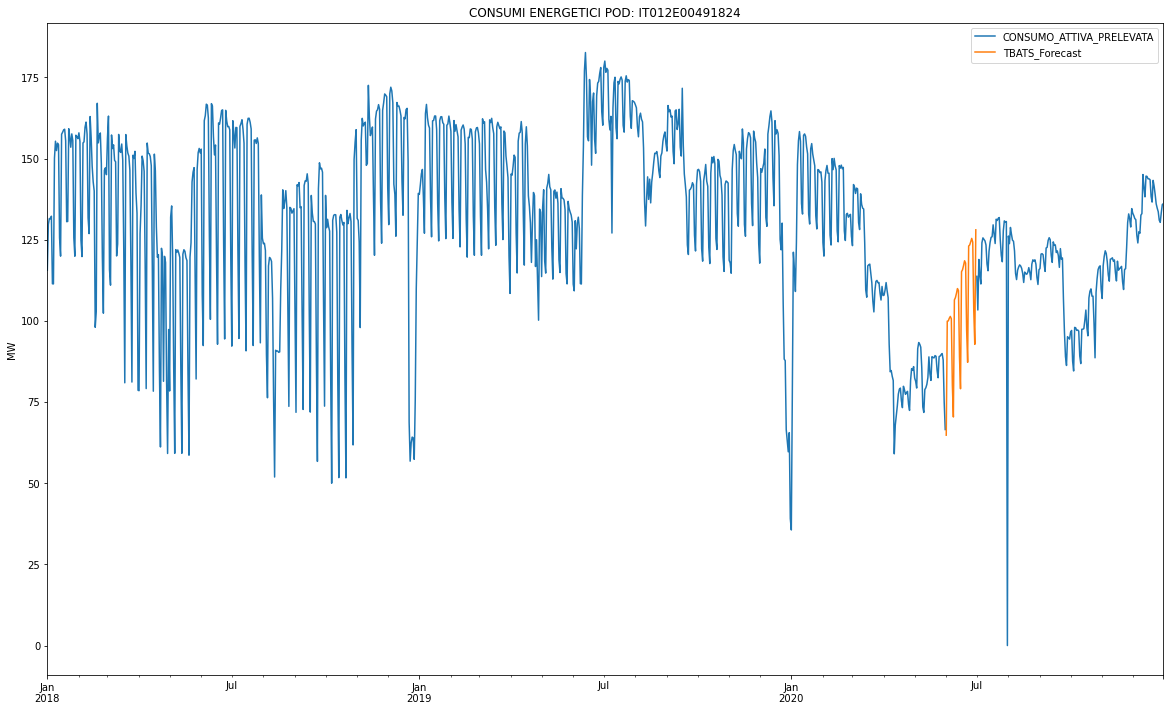

In [292]:
# Plot the forecasted values alongside the original data
title='CONSUMI ENERGETICI POD: IT012E00491824'
ylabel='MW'
xlabel='' 
df_complete.columns = ['CONSUMO_ATTIVA_PRELEVATA']
df_for.columns = ['TBATS_Forecast']
ax = df_complete.resample('d').mean().plot(legend=True,figsize=(20,12),title=title)
df_for['TBATS_Forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

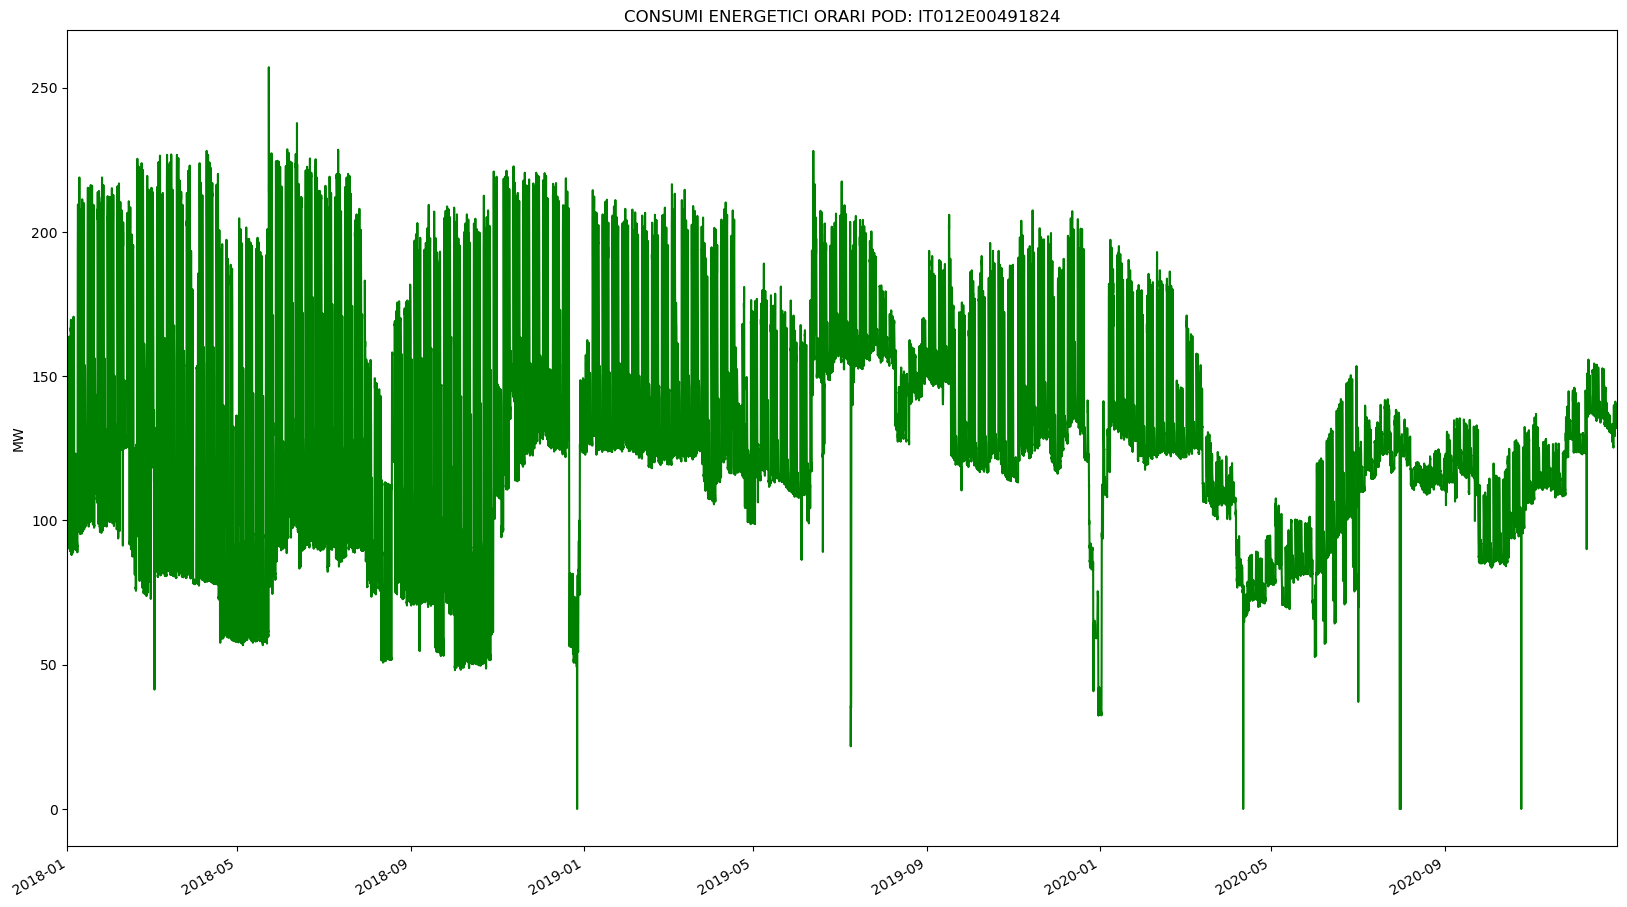

In [1148]:
# Plot the forecasted values alongside the original data
title='CONSUMI ENERGETICI ORARI POD: IT012E00491824'
ylabel='MW'
xlabel='' 
ax = df_complete_POD2.plot(legend=False,figsize=(20,12),title=title, color='green')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

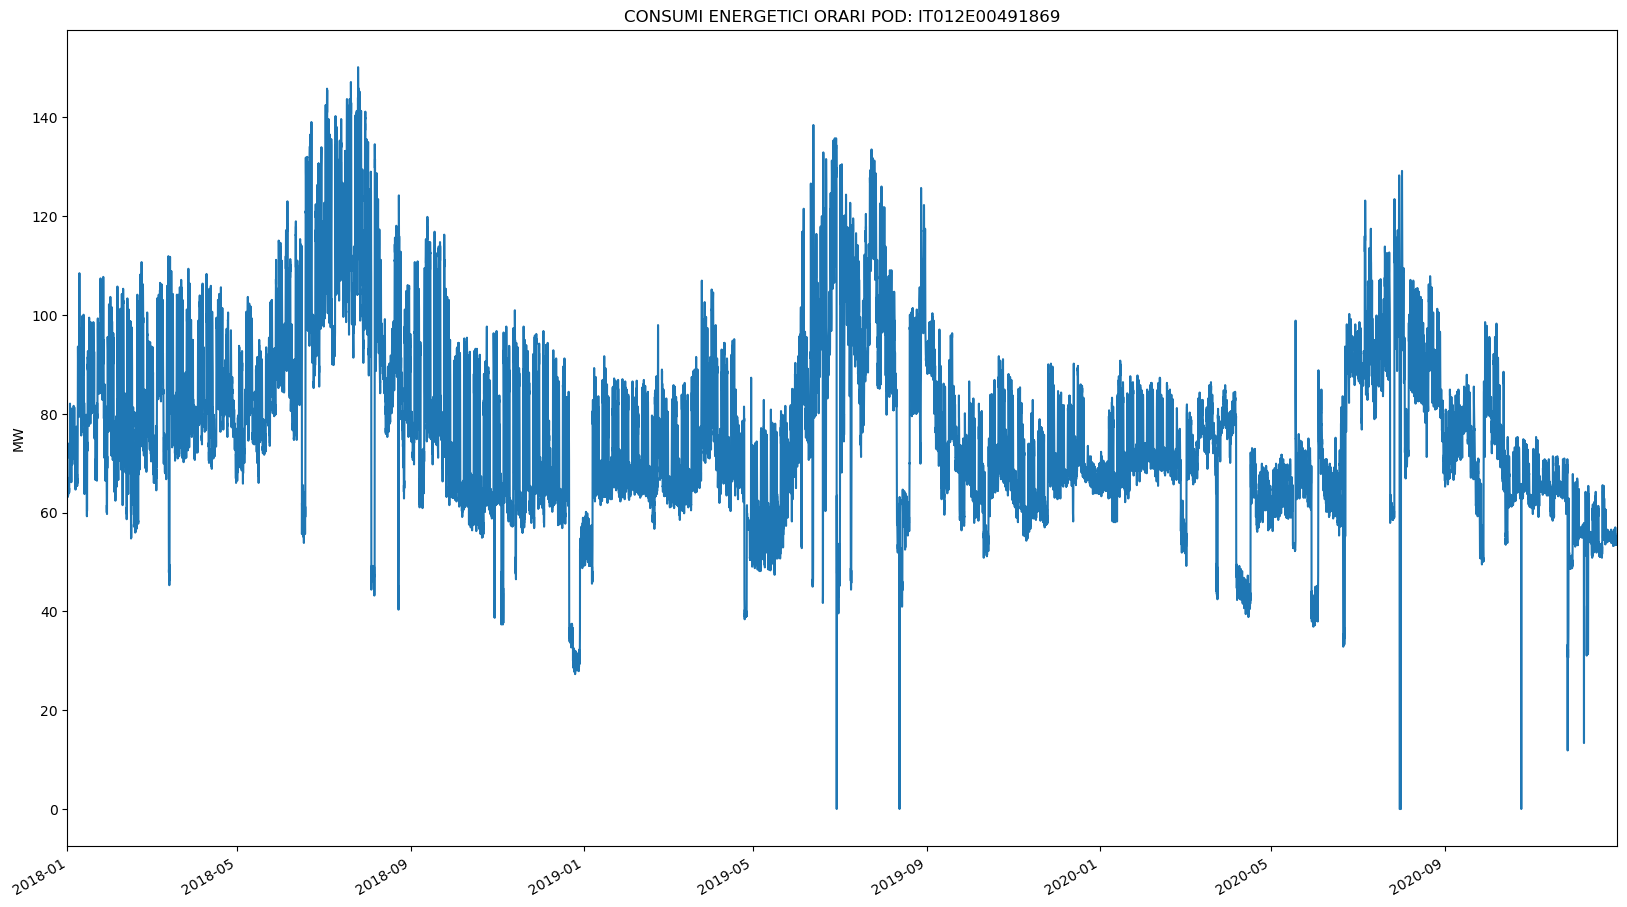

In [1150]:
# Plot the forecasted values alongside the original data
title='CONSUMI ENERGETICI ORARI POD: IT012E00491869'
ylabel='MW'
xlabel='' 
ax = df_complete_POD1.plot(legend=False,figsize=(20,12),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## SARIMA with long Stagionality
https://robjhyndman.com/hyndsight/longseasonality/

In [307]:
frame_MONTH = frame.groupby(['POD', 'YEAR', 'MONTH', 'DAY'], as_index=False).mean()
df = frame_MONTH[frame_MONTH['POD'] == 'IT012E00491824']
df['DATE_TIME'] = pd.to_datetime({'year':df['YEAR'], 'month':df['MONTH'], 'day':df['DAY']})
df = df.set_index('DATE_TIME')
df = df[['CONSUMO_ATTIVA_PRELEVATA']]
df.sort_index(ascending=True, inplace=True)
df_complete = df.copy()
df.columns = ['Y']


In [317]:
y = df.copy()
#y_to_train = y.loc[: '2020-05-30']
#y_to_test = y.loc['2020-05-30':]
n = 184
y_to_train = y.iloc[:(len(y)-n)]
#y_to_train = y
y_to_test = y.iloc[(len(y)-n):] # last year for testing

In [329]:
y_to_train, y_to_test

(                     Y
 DATE_TIME             
 2018-01-01  115.614583
 2018-01-02  129.731250
 2018-01-03  131.581771
 2018-01-04  131.444271
 2018-01-05  132.263542
 ...                ...
 2020-05-27   89.627083
 2020-05-28   89.947917
 2020-05-29   87.954167
 2020-05-30   74.874479
 2020-05-31   66.538542
 
 [882 rows x 1 columns],
                      Y
 DATE_TIME             
 2020-07-01  113.735417
 2020-07-02  103.371354
 2020-07-03  118.943229
 2020-07-04  114.027604
 2020-07-05  111.380729
 ...                ...
 2020-12-27  131.037500
 2020-12-28  130.367187
 2020-12-29  133.375000
 2020-12-30  135.855729
 2020-12-31  136.119271
 
 [184 rows x 1 columns])

In [323]:
# prepare Fourier terms
exog = pd.DataFrame({'date': y.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(y)-n)]
exog_to_test = exog.iloc[(len(y)-n):]
# Fit model
arima_exog_model = pmdarima.auto_arima(y=y_to_train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=n, exogenous=exog_to_test)

In [328]:
df_prev = pd.DataFrame(list(zip(l, y_arima_exog_forecast)), columns =['DATA', 'Y'])
df_prev = df_prev.set_index(pd.DatetimeIndex(df_prev['DATA']))
df_prev = df_prev.drop(['DATA'], axis=1)
df_prev.loc['2020-06-01':'2020-07-01']

Y
DATA                 
2020-06-01  80.064287
2020-06-02  80.547920
2020-06-03  80.976655
2020-06-04  81.692503
2020-06-05  81.200552
2020-06-06  73.587351
2020-06-07  70.637288
2020-06-08  77.638448
2020-06-09  78.077441
2020-06-10  78.460204
2020-06-11  79.125546
2020-06-12  78.592882
2020-06-13  71.005255
2020-06-14  68.034677
2020-06-15  74.918842
2020-06-16  75.302003
2020-06-17  75.628092
2020-06-18  76.232762
2020-06-19  75.649632
2020-06-20  68.077713
2020-06-21  65.077720
2020-06-22  71.837456
2020-06-23  72.157320
2020-06-24  72.419842
2020-06-25  72.957557
2020-06-26  72.318163
2020-06-27  64.756109
2020-06-28  61.721891
2020-06-29  68.353895
2020-06-30  68.607186
2020-07-01  68.803481

In [325]:
df_tot = pd.concat([df.loc[:'2020-05-30'], df_prev.loc[:'2020-12-31']], axis=0)
df_tot

Y
2018-01-01  115.614583
2018-01-02  129.731250
2018-01-03  131.581771
2018-01-04  131.444271
2018-01-05  132.263542
...                ...
2020-11-27   11.360767
2020-11-28    5.613420
2020-11-29    3.532371
2020-11-30    9.278487
2020-12-01    9.857724

[1065 rows x 1 columns]

In [194]:
df_TT = pd.concat([df, df_tot], axis=1)
df_TT.columns = ['Storico', 'Forecast']

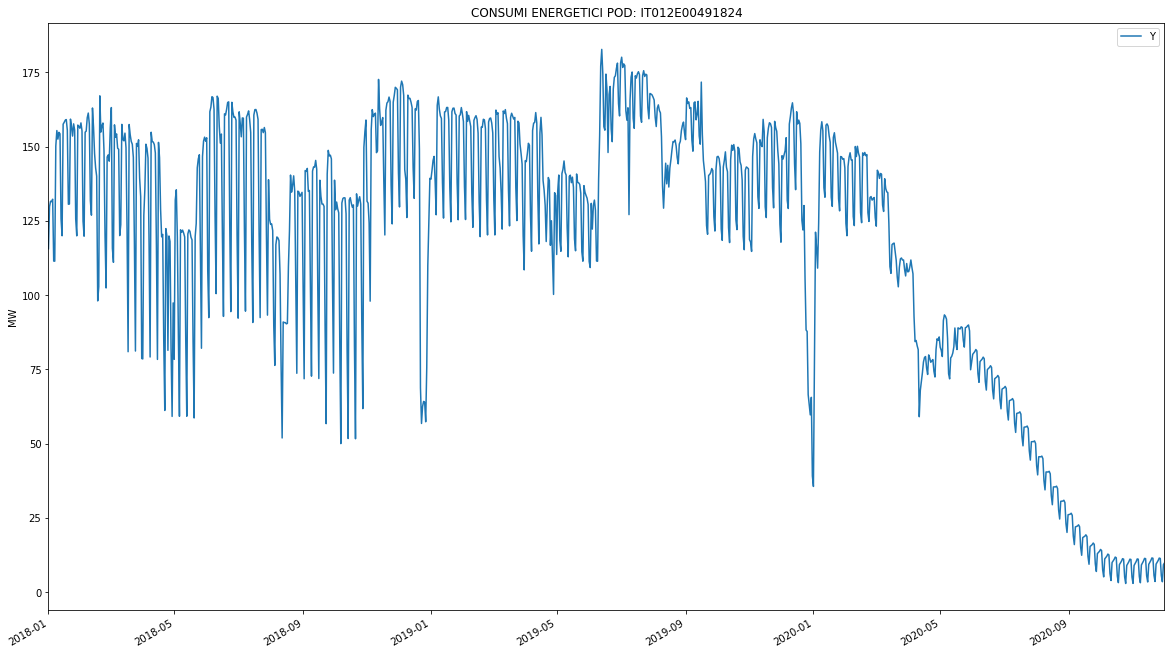

In [327]:
# Plot the forecasted values alongside the original data
title='CONSUMI ENERGETICI POD: IT012E00491824'
ylabel='MW'
xlabel='' 

ax = df_tot.plot(legend=True,figsize=(20,12),title=title)
#df_TT.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
# Split the data into train/test sets
ltt = math.floor(df.shape[0]/3)
train = df.iloc[:len(df)-ltt]
test = df.iloc[len(df)-ltt:]

## FbProphet
https://facebook.github.io/prophet/docs/quick_start.html

In [896]:
frame_MONTH = frame.groupby(['POD', 'YEAR', 'MONTH', 'DAY'], as_index=False).mean()
df = frame_MONTH[frame_MONTH['POD'] == 'IT012E00491824']
df['DATE_TIME'] = pd.to_datetime({'year':df['YEAR'], 'month':df['MONTH'], 'day':df['DAY']})
#df = df.set_index('DATE_TIME')
df = df[['DATE_TIME', 'CONSUMO_ATTIVA_PRELEVATA']]
#df.sort_index(ascending=True, inplace=True)
df.columns = ['ds','y']
df_train = df[df['ds']<'2020-06-01']

In [897]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_country_holidays(country_name='IT')
m.fit(df_train)
future = m.make_future_dataframe(periods=214, freq='D')
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


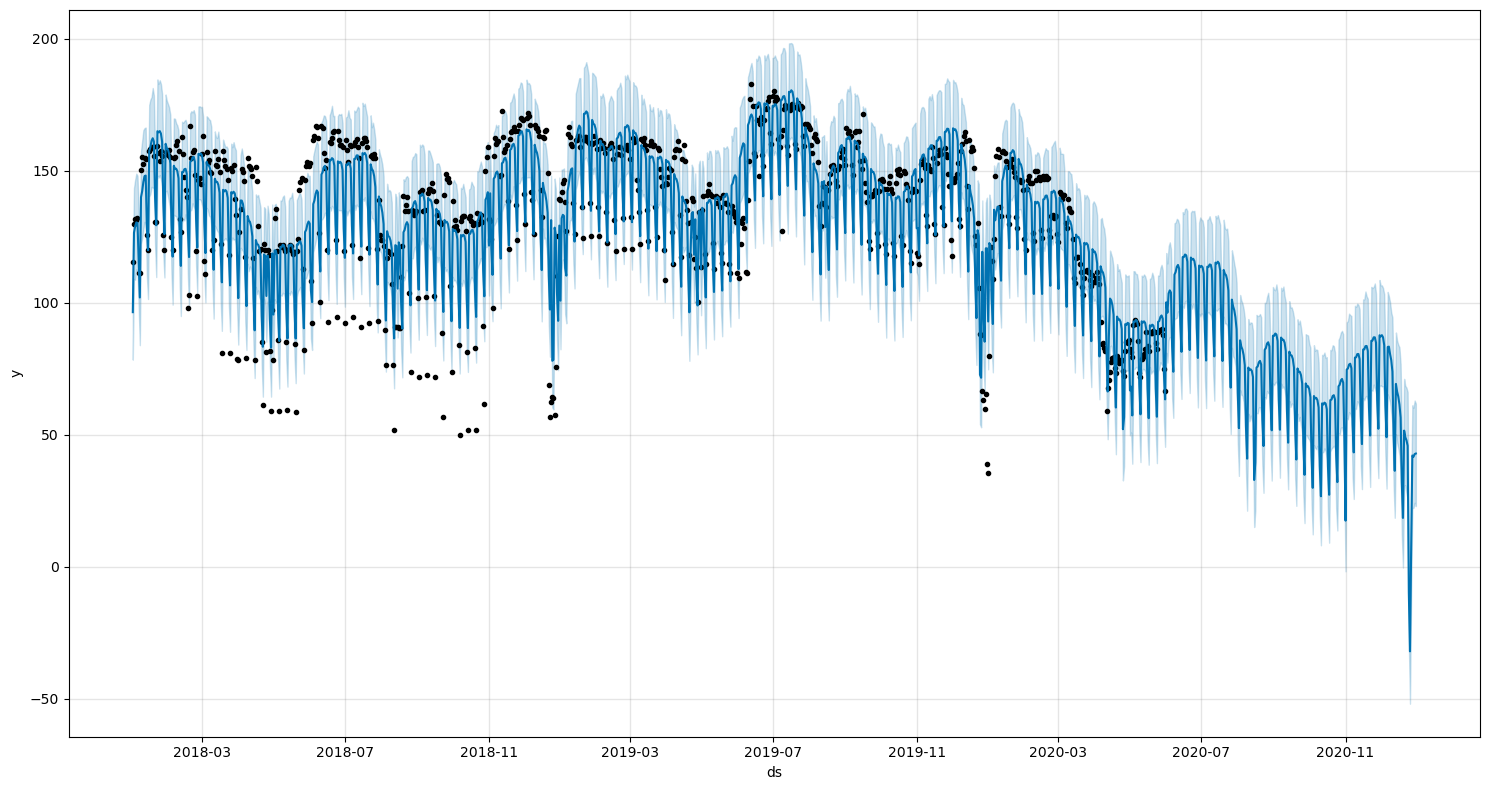

In [898]:
fig1 = m.plot(forecast, figsize=(15,8))

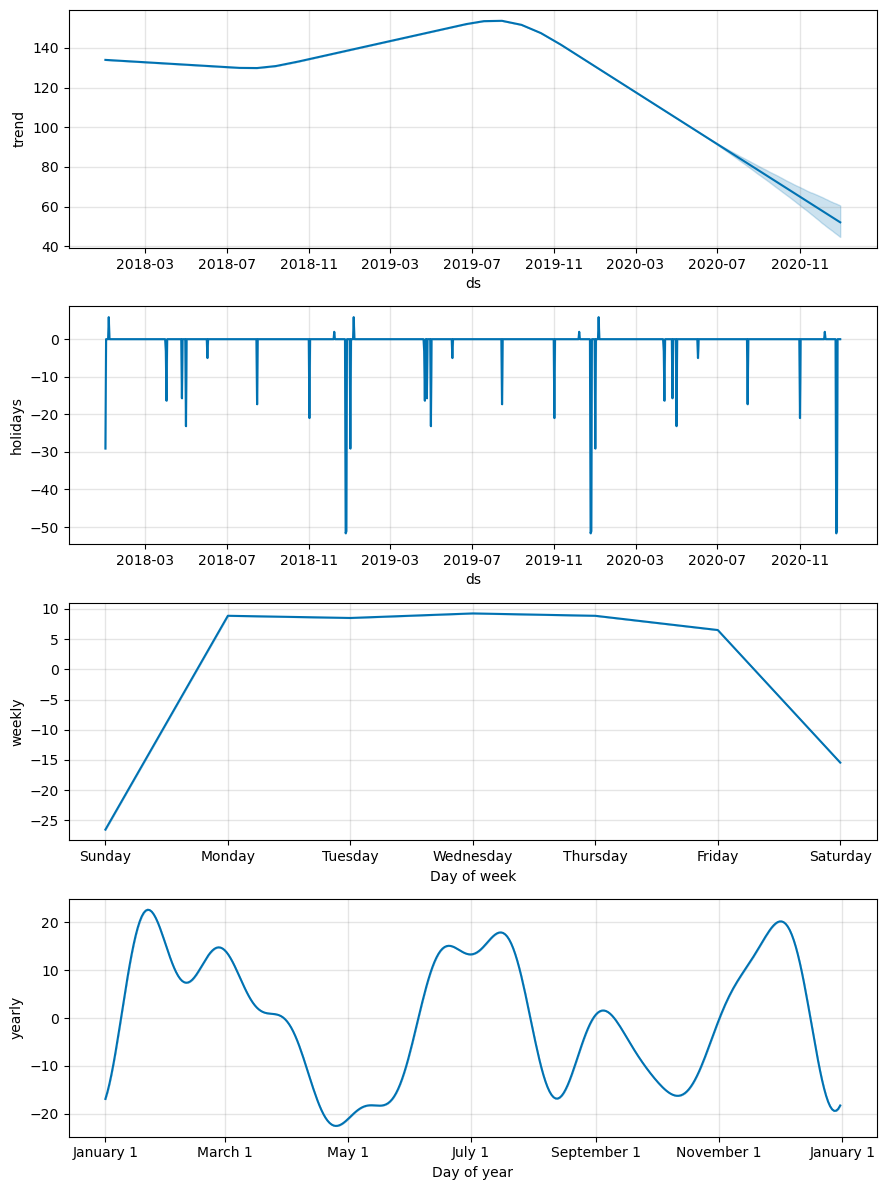

In [899]:
fig2 = m.plot_components(forecast)

In [900]:
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [901]:
forecast['ds'] = pd.to_datetime(forecast['ds'], format='%Y-%m-%d')
forecast = forecast.set_index('ds')

In [903]:
df_train = df.set_index('ds')
forecast = forecast.loc['2020-06-01':]
forecast.rename(columns = {'yhat' : 'fbProphet Forecast', 'yhat_lower' : 'fbProphet Forecast Lower bound',  'yhat_upper' : 'fbProphet Forecast Upper bound'}, inplace = True)
forecast

fbProphet Forecast  fbProphet Forecast Lower bound  \
ds                                                               
2020-06-01          100.193459                       81.105851   
2020-06-02           96.264351                       77.386383   
2020-06-03          103.559248                       85.850749   
2020-06-04          104.707475                       87.061781   
2020-06-05          103.899125                       86.808472   
...                        ...                             ...   
2020-12-27            7.248810                      -10.119949   
2020-12-28           42.185104                       22.162873   
2020-12-29           41.725984                       22.372263   
2020-12-30           42.726030                       24.256318   
2020-12-31           42.920721                       23.014450   

            fbProphet Forecast Upper bound  
ds                                          
2020-06-01                      118.846171  
2020-06-02                      114.906953  
2020-06-03                      121.396024  
2020-06-04                      122.917568  
2020-06-05                      120.431800  
...                                    ...  
2020-12-27                       28.042997  
2020-12-28                       61.210416  
2020-12-29                       60.258170  
2020-12-30                       62.987827  
2020-12-31                       61.875494  

[214 rows x 3 columns]

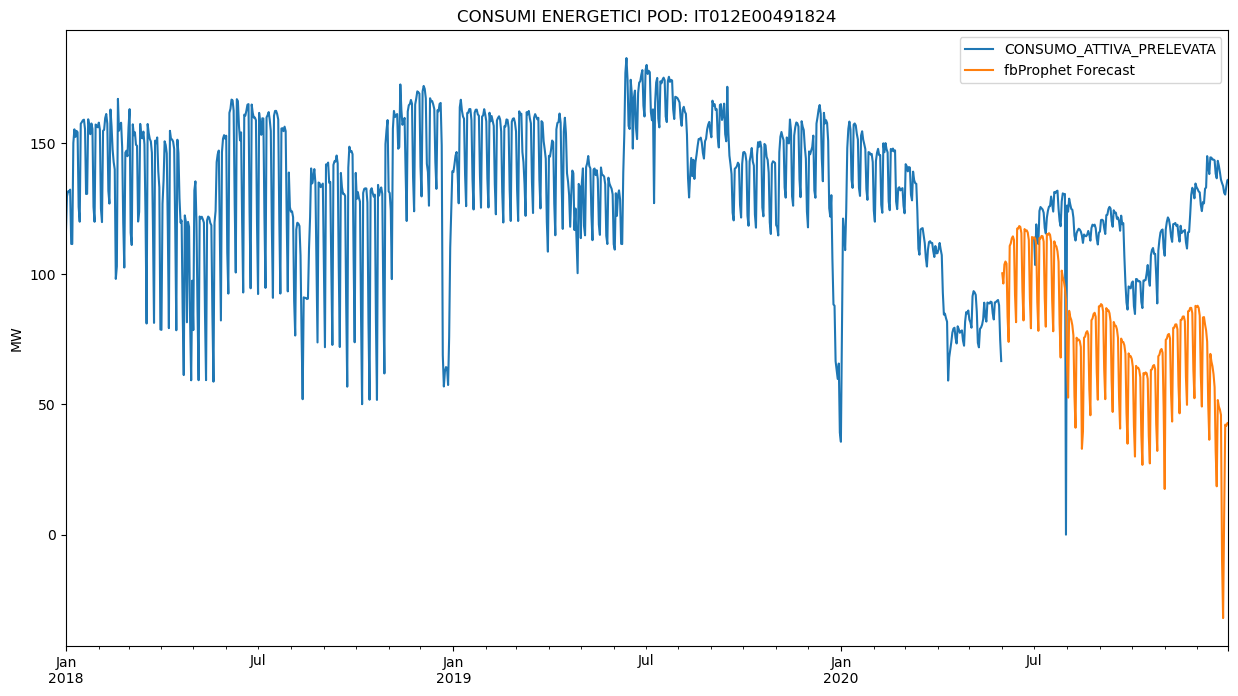

In [904]:
# Plot the forecasted values alongside the original data
title='CONSUMI ENERGETICI POD: IT012E00491824'
ylabel='MW'
xlabel='' 
df_train.columns = ['CONSUMO_ATTIVA_PRELEVATA']
ax = df_train.resample('d').mean().plot(legend=True,figsize=(15,8),title=title)
forecast['fbProphet Forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

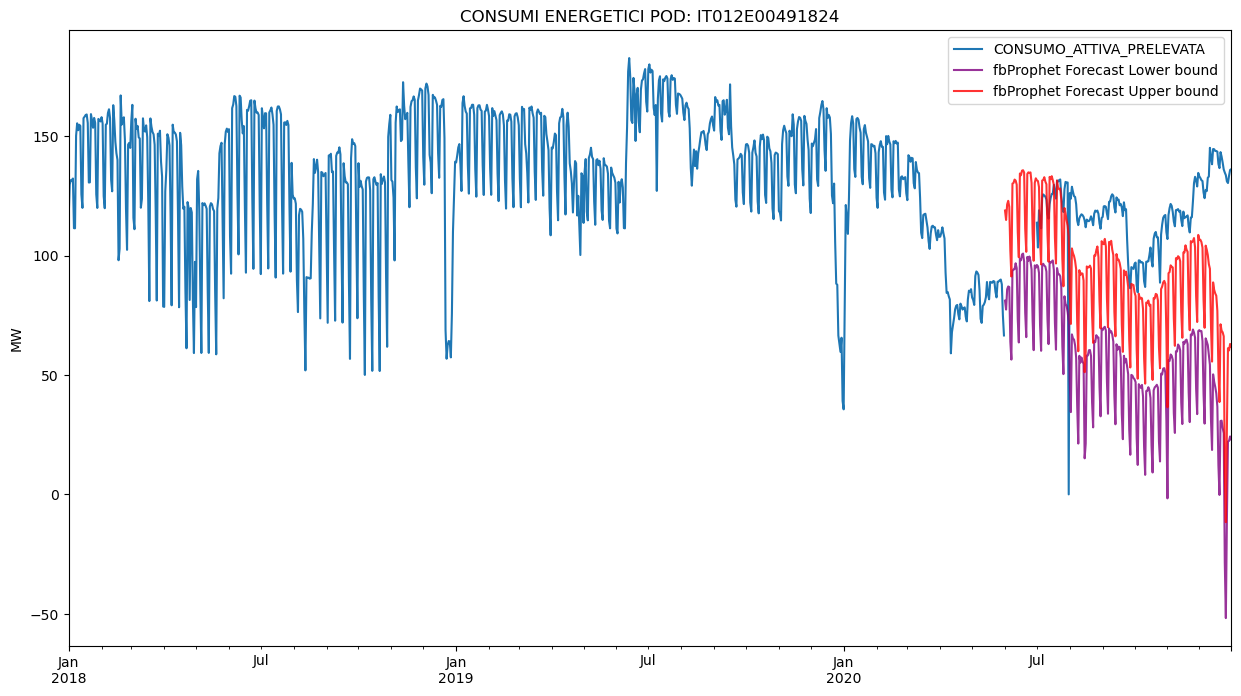

In [905]:
# Plot the forecasted values alongside the original data
title='CONSUMI ENERGETICI POD: IT012E00491824'
ylabel='MW'
xlabel='' 
df_train.columns = ['CONSUMO_ATTIVA_PRELEVATA']
ax = df_train.resample('d').mean().plot(legend=True,figsize=(15,8),title=title)
forecast['fbProphet Forecast Lower bound'].plot(legend=True, color='purple', alpha=0.8)
forecast['fbProphet Forecast Upper bound'].plot(legend=True, color='red', alpha=0.8)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


## SARIMAX
forecast su test

In [970]:
frame_HOUR = frame.groupby(['POD', 'YEAR', 'MONTH', 'DAY', 'HOUR'], as_index=False).mean()
df = frame_HOUR[frame_HOUR['POD'] == 'IT012E00491869']
df['DATE_TIME'] = pd.to_datetime({'year':df['YEAR'], 'month':df['MONTH'], 'day':df['DAY'], 'hour':df['HOUR']})
df = df.set_index('DATE_TIME')
df = df[['CONSUMO_ATTIVA_PRELEVATA']]
df.sort_index(ascending=True, inplace=True)
df.columns = ['Y']
df_orig = df.copy()

In [971]:
hour_fcast = 19

In [972]:
df = df_orig[df_orig.index.hour == hour_fcast]
df.index = df.index.date

In [973]:
df = pd.merge(df, df_cal_holiday[['dummy_holiday', 'dummy_Covid']], left_index=True, right_index=True)
df

Y  dummy_holiday  dummy_Covid
2018-01-01  64.20              1            0
2018-01-02  71.10              0            0
2018-01-03  67.95              0            0
2018-01-04  70.80              0            0
2018-01-05  71.85              0            0
...           ...            ...          ...
2020-12-27  54.45              0            1
2020-12-28  53.85              0            1
2020-12-29  55.80              0            1
2020-12-30  53.70              0            1
2020-12-31  53.55              0            1

[1096 rows x 3 columns]

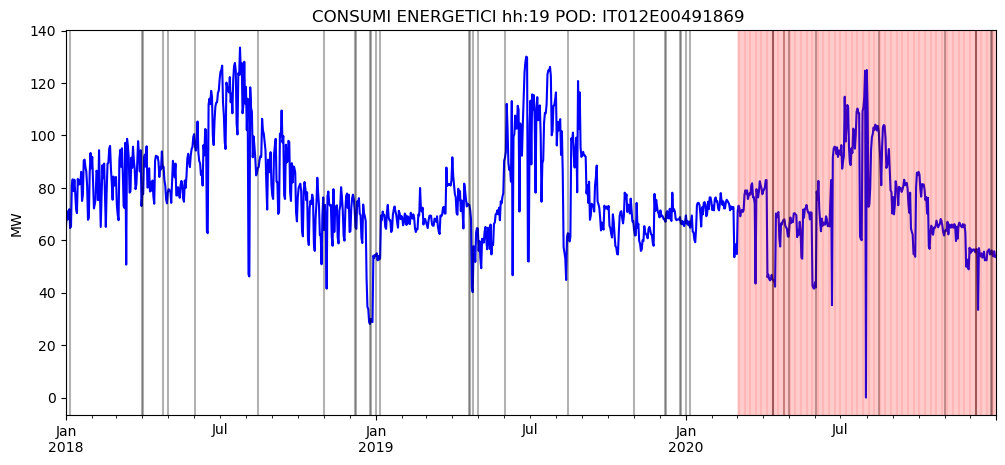

In [974]:
# Plot the source data
title=f'CONSUMI ENERGETICI hh:{hour_fcast} POD: IT012E00491869 '
ylabel='MW'
xlabel='' 
ax = df['Y'].plot(figsize=(12,5),title=title, color = 'blue', legend=False)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
for x in df_1.query('dummy_holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3)
for x in df_1.query('dummy_Covid==1').index: 
    ax.axvline(x=x, color='r', alpha = 0.1);

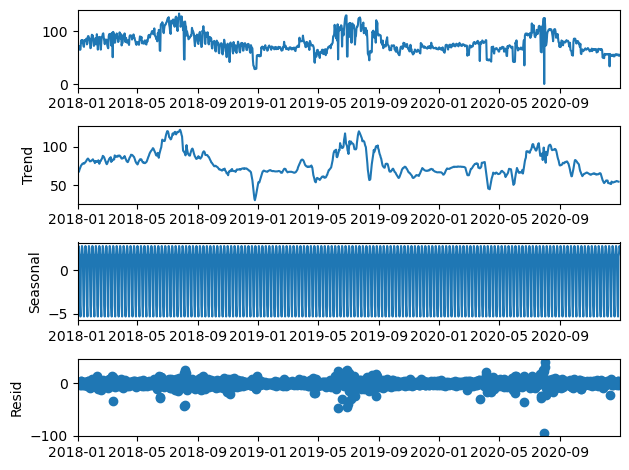

In [975]:
df.index.freq = 'd'
result = seasonal_decompose(df[['Y']], model='add')
result.plot();

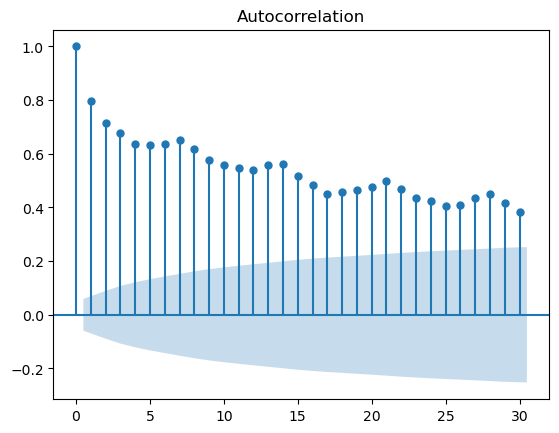

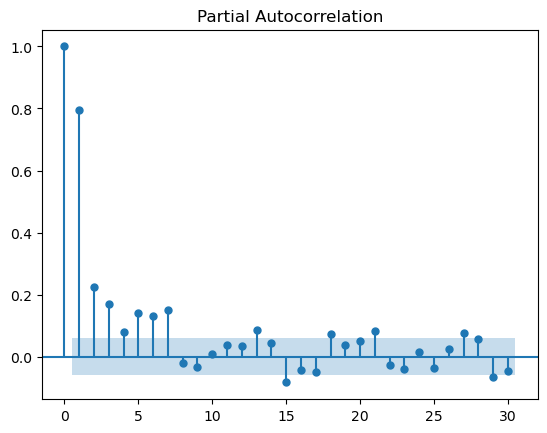

In [976]:
# Draw ACF and PACF Plot Charts
plot_acf(df[['Y']].values.squeeze(), lags=30)
plot_pacf(df[['Y']].values.squeeze(), lags=30)
plt.show()

In [960]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [961]:
adf_test(df['Y'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.584432
p-value                    0.096258
# lags used               20.000000
# observations          1075.000000
critical value (1%)       -3.436448
critical value (5%)       -2.864232
critical value (10%)      -2.568204
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [962]:
Msarima = pmdarima.auto_arima(df['Y'], seasonal=True, m=7)

In [963]:
Msarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1096
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -4056.585
Date:                                Sat, 01 May 2021   AIC                           8131.170
Time:                                        17:09:22   BIC                           8176.156
Sample:                                             0   HQIC                          8148.192
                                               - 1096                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.002     -0.092      0.927      -0.003       0.003
ar.L1          0.4773      0.017     27.365      0.000       0.443       0.511
ar.L2          0.1252      0.019      6.507      0.000       0.087       0.163
ar.L3          0.1284      0.022      5.937      0.000       0.086       0.171
ma.L1         -0.9650      0.012    -83.614      0.000      -0.988      -0.942
ar.S.L7        0.9662      0.016     60.058      0.000       0.935       0.998
ma.S.L7       -0.8861      0.024    -36.413      0.000      -0.934      -0.838
ma.S.L14    4.957e-05      0.024      0.002      0.998      -0.046       0.046
sigma2        99.0621      2.167     45.724      0.000      94.816     103.308
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             26369.63
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [964]:
# Run pmdarima.auto_arima to obtain recommended orders
par = Msarima.get_params()
order = par['order']
seasonal_order = par['seasonal_order']

In [991]:
# Set four weeks for testing
train = df.iloc[:len(df)-31]
test = df.iloc[len(df)-31:]

In [992]:
model = SARIMAX(train['Y'], order = order, seasonal_order=seasonal_order, enforce_invertibility = False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      Y   No. Observations:                 1065
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -3954.857
Date:                                Sat, 01 May 2021   AIC                           7925.713
Time:                                        17:15:19   BIC                           7965.471
Sample:                                    01-01-2018   HQIC                          7940.778
                                         - 11-30-2020                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5342      0.016     33.199      0.000       0.503       0.566
ar.L2          0.1666      0.018      9.112      0.000       0.131       0.202
ar.L3          0.1683      0.018      9.112      0.000       0.132       0.205
ma.L1         -0.9997      0.013    -77.647      0.000      -1.025      -0.975
ar.S.L7        0.9904      0.005    194.594      0.000       0.980       1.000
ma.S.L7       -0.9299      0.018    -50.411      0.000      -0.966      -0.894
ma.S.L14      -0.0078      0.019     -0.408      0.683      -0.045       0.030
sigma2        98.8180      2.410     41.006      0.000      94.095     103.541
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):             25823.59
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [993]:
fcast = results.predict(start=len(df)-31, end=len(df)-1, typ='levels').rename(f'SARIMA{order}{seasonal_order} Forecast')
fcast

2020-12-01    56.995767
2020-12-02    58.965294
2020-12-03    61.024607
2020-12-04    58.786715
2020-12-05    60.367316
2020-12-06    60.190790
2020-12-07    63.456782
2020-12-08    64.081013
2020-12-09    65.735962
2020-12-10    67.013489
2020-12-11    64.357856
2020-12-12    65.545406
2020-12-13    64.935531
2020-12-14    67.757800
2020-12-15    68.041199
2020-12-16    69.359477
2020-12-17    70.328190
2020-12-18    67.429814
2020-12-19    68.359294
2020-12-20    67.528898
2020-12-21    70.116928
2020-12-22    70.207713
2020-12-23    71.339290
2020-12-24    72.139229
2020-12-25    69.122506
2020-12-26    69.909132
2020-12-27    68.963964
2020-12-28    71.414690
2020-12-29    71.401529
2020-12-30    72.427793
2020-12-31    73.133498
Freq: D, Name: SARIMA(3, 1, 1)(1, 0, 2, 7) Forecast, dtype: float64

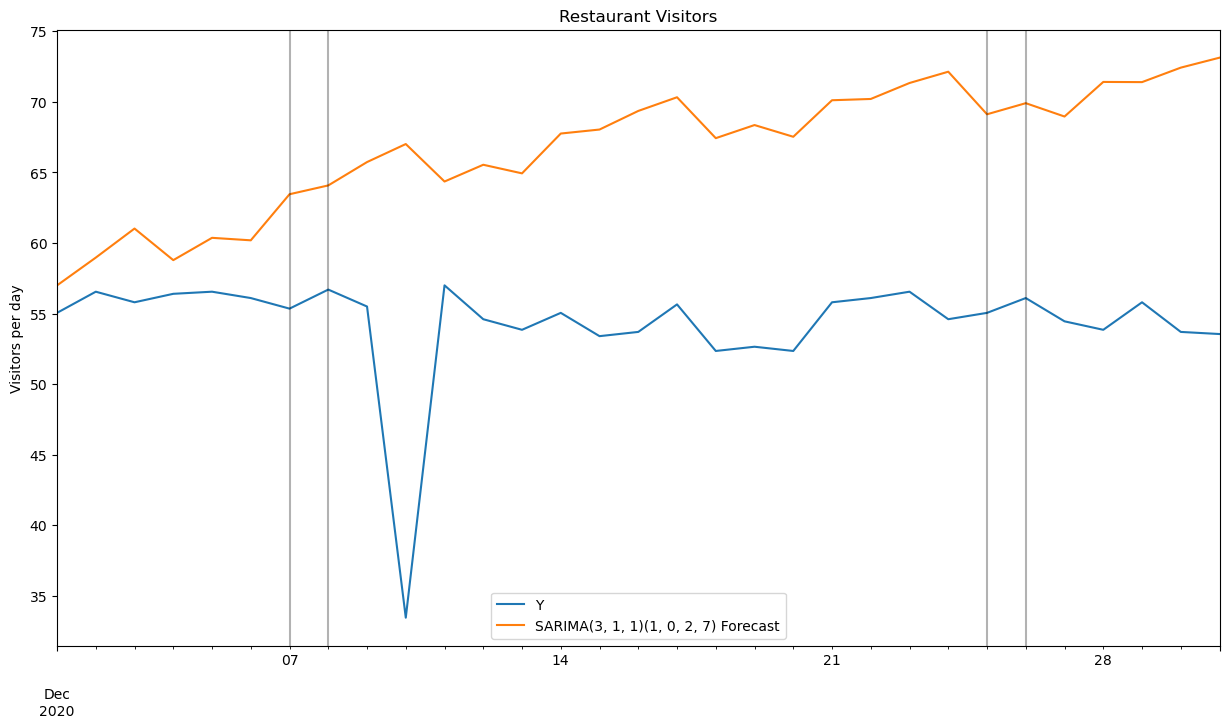

In [994]:
# Plot predictions against known values
title=f'CONSUMI ENERGETICI hh:{hour_fcast} POD: IT012E00491869 '
ylabel='MW'
xlabel=''

ax = test['Y'].plot(legend=True,figsize=(15,8),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('dummy_holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [995]:
error1 = mse(test['Y'], fcast)
error2 = rmse(test['Y'], fcast)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 196.1043559
SARIMA(1,0,0)(2,0,0,7) RMSE Error:  14.0037265


### Exog variable

In [996]:
model = SARIMAX(train['Y'],exog=train['dummy_holiday'], order=order, seasonal_order=seasonal_order, enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      Y   No. Observations:                 1065
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -3945.107
Date:                                Sat, 01 May 2021   AIC                           7908.215
Time:                                        17:17:32   BIC                           7952.943
Sample:                                    01-01-2018   HQIC                          7925.163
                                         - 11-30-2020                                         
Covariance Type:                                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
dummy_holiday    -2.3770      2.338     -1.017      0.309      -6.959       2.205
ar.L1             0.4012      0.027     14.614      0.000       0.347       0.455
ar.L2             0.0825      0.023      3.597      0.000       0.038       0.127
ar.L3             0.0747      0.024      3.104      0.002       0.028       0.122
ma.L1            -0.8973      0.025    -35.204      0.000      -0.947      -0.847
ar.S.L7           0.9941      0.003    324.921      0.000       0.988       1.000
ma.S.L7          -0.9402      0.021    -45.055      0.000      -0.981      -0.899
ma.S.L14         -0.0164      0.021     -0.789      0.430      -0.057       0.024
sigma2           96.6895      1.808     53.465      0.000      93.145     100.234
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             26320.37
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1000]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['dummy_holiday']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

In [1001]:
predictions

2020-12-01    56.660967
2020-12-02    57.872441
2020-12-03    58.811407
2020-12-04    55.606081
2020-12-05    56.146772
2020-12-06    54.909156
2020-12-07    55.139687
2020-12-08    55.093915
2020-12-09    58.414463
2020-12-10    59.063681
2020-12-11    55.571995
2020-12-12    56.023117
2020-12-13    54.666052
2020-12-14    57.085683
2020-12-15    56.997550
2020-12-16    57.894736
2020-12-17    58.507352
2020-12-18    55.016450
2020-12-19    55.451261
2020-12-20    54.092602
2020-12-21    56.491596
2020-12-22    56.399589
2020-12-23    57.288501
2020-12-24    57.895471
2020-12-25    52.046648
2020-12-26    52.477952
2020-12-27    53.503628
2020-12-28    55.888097
2020-12-29    55.796325
2020-12-30    56.679813
2020-12-31    57.283079
Freq: D, Name: SARIMAX Predictions, dtype: float64

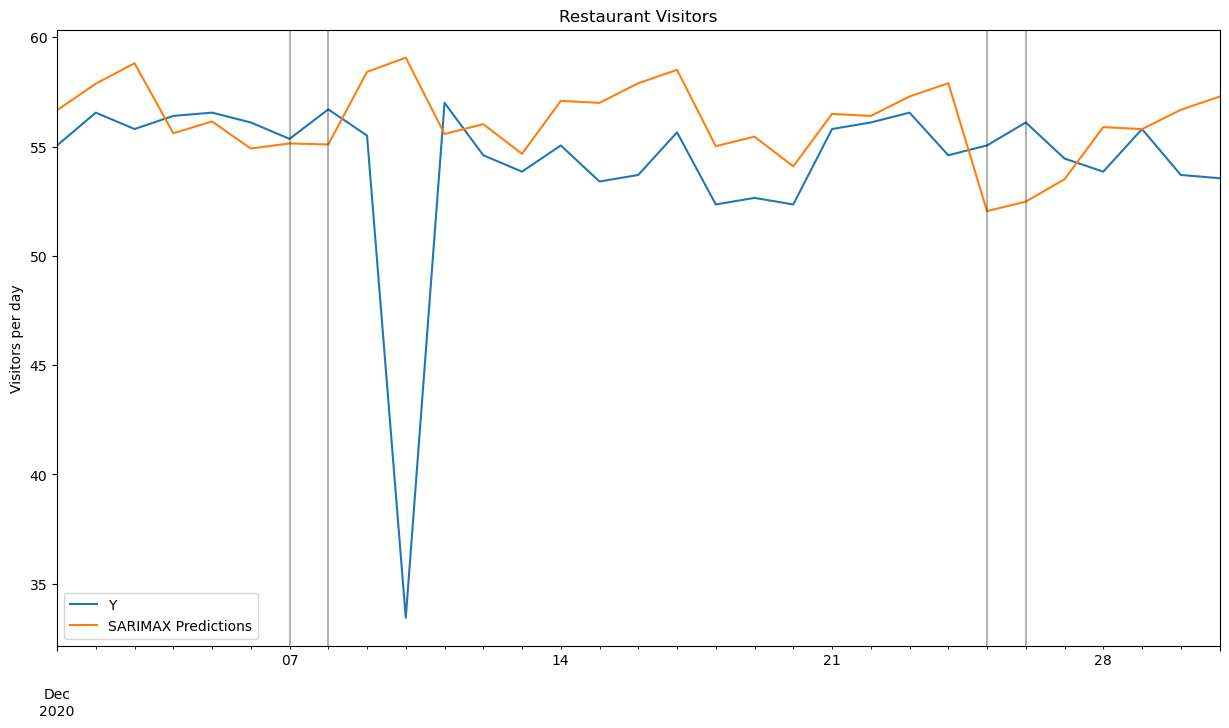

In [1003]:
# Plot predictions against known values
title=f'CONSUMI ENERGETICI hh:{hour_fcast} POD: IT012E00491869 '
ylabel='MW'
xlabel=''

ax = test['Y'].plot(legend=True,figsize=(15,8),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('dummy_holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [1005]:
# Print values from SARIMA above
print(f'SARIMA MSE Error: {error1:11.10}')
print(f'SARIMA RMSE Error: {error2:11.10}')
print()

error1x = mse(test['Y'], fcast)
error2x = rmse(test['Y'], predictions)

# Print new SARIMAX values
print(f'SARIMAX MSE Error: {error1x:11.10}')
print(f'SARIMAX RMSE Error: {error2x:11.10}')

SARIMA MSE Error: 196.1043559
SARIMA RMSE Error:  14.0037265

SARIMAX MSE Error: 196.1043559
SARIMAX RMSE Error: 5.112762147


## SARIMAX
Forecast su futuro

In [1090]:
hour_fcast

19

In [1057]:
df = df_orig[df_orig.index.hour == hour_fcast]
df.index = df.index.date

In [1058]:
df = pd.merge(df, df_cal_holiday[['dummy_holiday', 'dummy_Covid']], left_index=True, right_index=True, how='outer')
df = df.loc[:'2020-12-31']

In [1059]:
model = SARIMAX(df['Y'], exog=df['dummy_holiday'], order=order, seasonal_order=seasonal_order, enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      Y   No. Observations:                 1096
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -4058.915
Date:                                Sat, 01 May 2021   AIC                           8135.830
Time:                                        17:34:08   BIC                           8180.817
Sample:                                    01-01-2018   HQIC                          8152.853
                                         - 12-31-2020                                         
Covariance Type:                                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
dummy_holiday    -2.0896      2.418     -0.864      0.388      -6.830       2.650
ar.L1             0.5258      0.015     33.980      0.000       0.495       0.556
ar.L2             0.1610      0.018      8.998      0.000       0.126       0.196
ar.L3             0.1749      0.018      9.557      0.000       0.139       0.211
ma.L1            -1.0000      0.189     -5.281      0.000      -1.371      -0.629
ar.S.L7           0.9877      0.006    155.882      0.000       0.975       1.000
ma.S.L7          -0.9198      0.018    -49.913      0.000      -0.956      -0.884
ma.S.L14         -0.0073      0.019     -0.378      0.705      -0.045       0.031
sigma2           96.2741     17.842      5.396      0.000      61.305     131.244
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             26309.54
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                            -1.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1060]:
# Obtain predicted values
start=len(df)
end=len(df)+len(df)-1
exog_forecast = df[['dummy_holiday']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')

In [1063]:
predictions = predictions[:30]

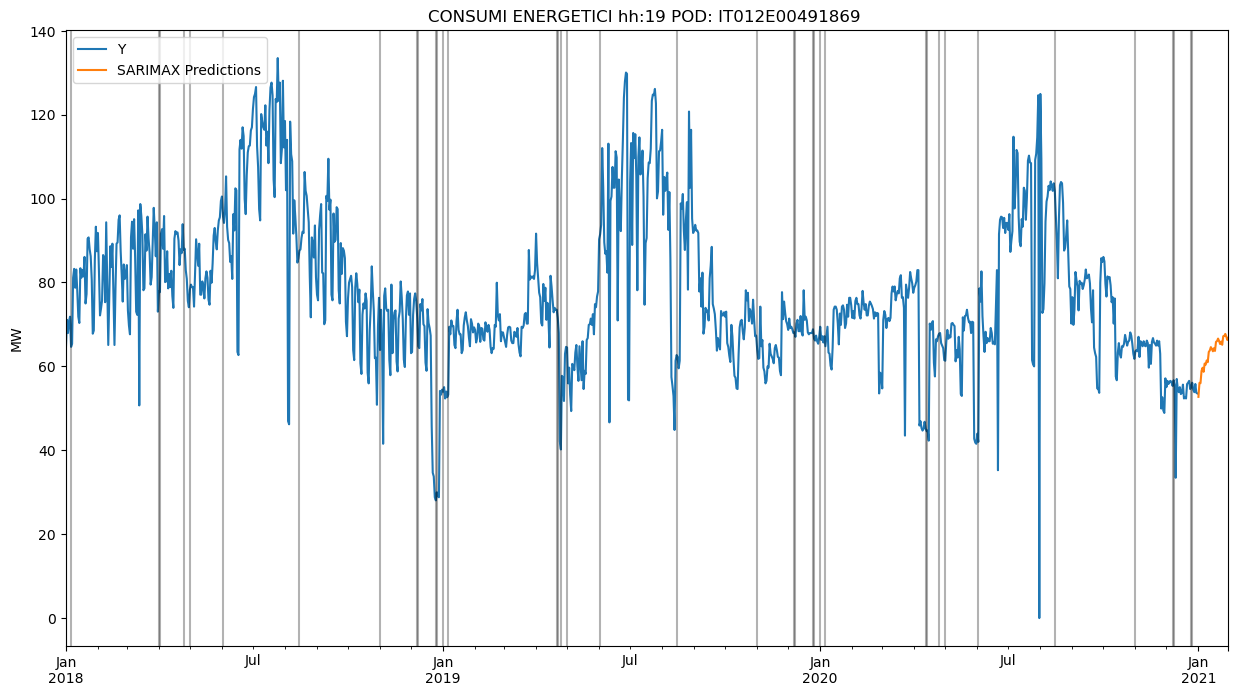

In [1066]:
# Plot predictions against known values
title=f'CONSUMI ENERGETICI hh:{hour_fcast} POD: IT012E00491869 '
ylabel='MW'
xlabel=''

ax = df['Y'].plot(legend=True,figsize=(15,8),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('dummy_holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## Analisi per POD: IT012E00491824

In [1159]:
print(f'Analisi sull\' ora {hour_fcast}')

Analisi sull' ora 19


In [1160]:
df = df_complete_POD2[df_complete_POD2.index.hour == hour_fcast]
df.index = df.index.date

In [1161]:
df = pd.merge(df, df_cal_holiday[['dummy_holiday', 'dummy_Covid']], left_index=True, right_index=True, how='outer')
df = df.loc[:'2020-12-31']


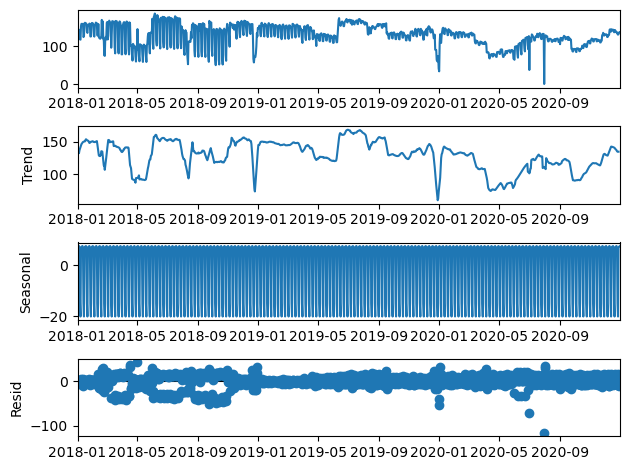

In [1166]:
df.index.freq = 'd'
result = seasonal_decompose(df[['Y']], model='add')
result.plot();

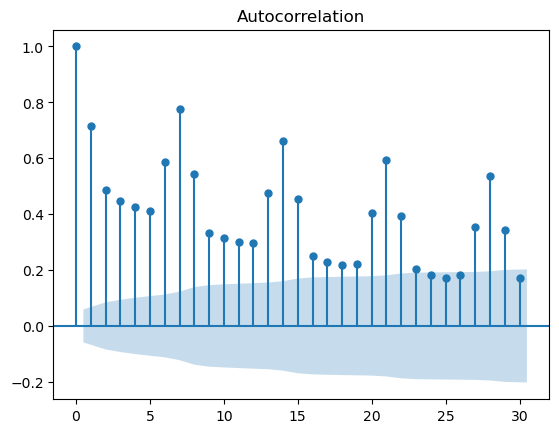

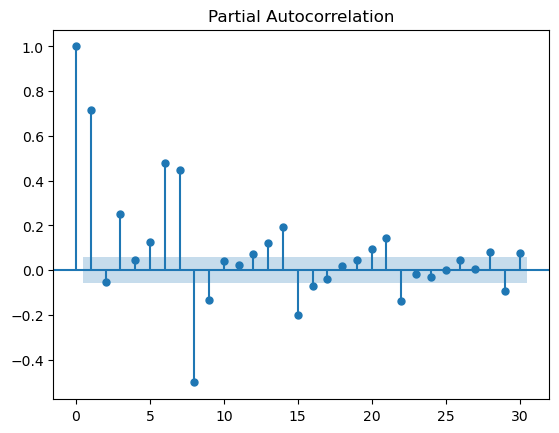

In [1168]:
# Draw ACF and PACF Plot Charts
plot_acf(df[['Y']].values.squeeze(), lags=30)
plot_pacf(df[['Y']].values.squeeze(), lags=30)
plt.show()

In [1169]:
Msarima = pmdarima.auto_arima(df['Y'], seasonal=True, m=7)

In [1170]:
Msarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1096
Model:             SARIMAX(3, 1, 0)x(2, 0, [1, 2], 7)   Log Likelihood               -4287.095
Date:                                Sat, 01 May 2021   AIC                           8590.190
Time:                                        23:49:53   BIC                           8630.178
Sample:                                             0   HQIC                          8605.321
                                               - 1096                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2887      0.010    -29.230      0.000      -0.308      -0.269
ar.L2         -0.1976      0.024     -8.221      0.000      -0.245      -0.150
ar.L3         -0.0902      0.030     -3.034      0.002      -0.148      -0.032
ar.S.L7        1.5777      0.176      8.955      0.000       1.232       1.923
ar.S.L14      -0.5815      0.174     -3.350      0.001      -0.922      -0.241
ma.S.L7       -1.2767      0.185     -6.896      0.000      -1.640      -0.914
ma.S.L14       0.3497      0.144      2.430      0.015       0.068       0.632
sigma2       145.7720      1.822     79.988      0.000     142.200     149.344
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             29465.07
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1171]:
# Run pmdarima.auto_arima to obtain recommended orders
par = Msarima.get_params()
order = par['order']
seasonal_order = par['seasonal_order']

In [1172]:
model = SARIMAX(df['Y'], exog=df['dummy_holiday'], order=order, seasonal_order=seasonal_order, enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      Y   No. Observations:                 1096
Model:             SARIMAX(3, 1, 0)x(2, 0, [1, 2], 7)   Log Likelihood               -4281.681
Date:                                Sat, 01 May 2021   AIC                           8581.362
Time:                                        23:50:07   BIC                           8626.348
Sample:                                    01-01-2018   HQIC                          8598.384
                                         - 12-31-2020                                         
Covariance Type:                                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
dummy_holiday    -6.5371      1.481     -4.415      0.000      -9.439      -3.635
ar.L1            -0.3003      0.010    -29.142      0.000      -0.320      -0.280
ar.L2            -0.2006      0.025     -7.899      0.000      -0.250      -0.151
ar.L3            -0.0910      0.030     -3.035      0.002      -0.150      -0.032
ar.S.L7           1.6210      0.181      8.948      0.000       1.266       1.976
ar.S.L14         -0.6248      0.178     -3.509      0.000      -0.974      -0.276
ma.S.L7          -1.3078      0.190     -6.901      0.000      -1.679      -0.936
ma.S.L14          0.3766      0.144      2.616      0.009       0.094       0.659
sigma2          149.5168      1.967     76.032      0.000     145.663     153.371
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             28902.49
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.41
Prob(H) (two-sided):                  0.01   Kurtosis:                        28.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1176]:
# Obtain predicted values
start=len(df)
end=len(df)+len(df)-1
exog_forecast = df[['dummy_holiday']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX Predictions')
predictions = predictions[:30]

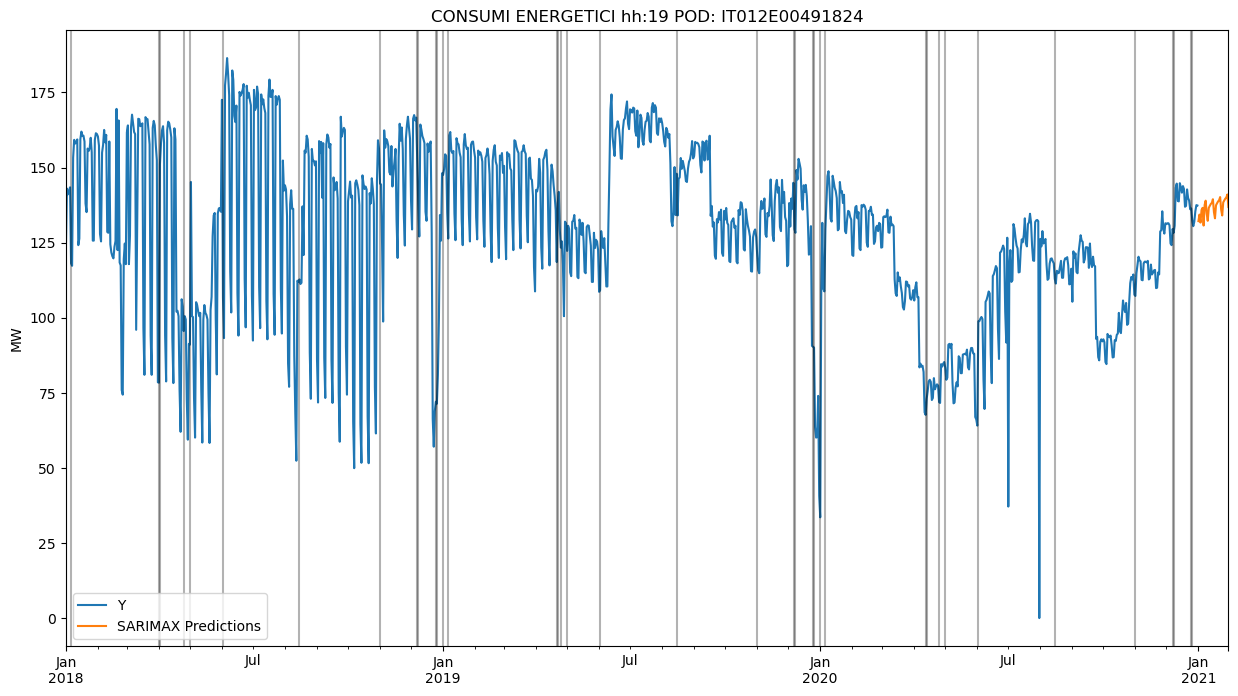

In [1183]:
# Plot predictions against known values
title=f'CONSUMI ENERGETICI hh:{hour_fcast} POD: {POD_2}'
ylabel='MW'
xlabel=''
ax = df['Y'].plot(legend=True,figsize=(15,8),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('dummy_holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);